## Import Libraries

In [1]:
import joblib
import re
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Tuple

from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler,LabelEncoder, MinMaxScaler, MaxAbsScaler, RobustScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier, 
    VotingClassifier, 
    AdaBoostClassifier
    )
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings("ignore")

from utils_machine_learning import(
    rename_columns_to_snake_case,
    check_df_with_commentries,
    grab_col_names,
    check_df,
    cat_summary,
    num_summary,
    correlation_matrix,
    high_correlated_cols,
    target_summary_with_num,
    score_classifier,
    plot_confusion_matrix,
    plot_roc_auc_curve_seaborn,
    get_feature_importance_scores,
)

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Load Datasets

In [9]:
# load the dataset
def load_dataset() -> pd.DataFrame:
    """
    Load the dataset from the CSV file and return it as a pandas DataFrame.

    Args:
        None

    Returns:
        pd.DataFrame: The dataset loaded from the CSV file.
    """

    data_path = "/Users/donadviser/github-projects/classify-online-shopper-intension-mlops/data/market_response_cleaned.csv"
    data = pd.read_csv(data_path, sep=",")
    return data

In [10]:
data_raw = load_dataset()
data_raw.shape

(12330, 18)

In [11]:
check_df_with_commentries(data_raw, target_col='purchased')

============= OBSERVATIONS ==============
>> The shape of the dataset is (12330, 18), comprising of 12330 rows and 18 columns
>> The data types have int64: 7, float64: 7, object: 2, bool: 2
>> There are 125 duplicate rows. These duplicate rows have to be deleted
>> There are 0 null values
An error occurred while checking the DataFrame: 'purchased'


In [12]:
(data_raw
        # .shape # The shape of the Dataframe
        # .info() # structure and data types
        # .duplicated().sum()  # Check for duplicate rows
        # .isnull().sum()  # Check for missing values in each column
        # .isnull().sum().sum() # Check the total number of missing values
        # .y.value_counts() # Counts the unique values of the target column
        # .columns  # List column names
        # .value_counts(dropna=False)  # Count unique values in each column, including NaN
        # .nunique()  # Count unique values in each column (excluding NaN)
        # .describe(include=['float', 'int']).T # Summary statistics to detect anomalies
        # .select_dtypes(include=['object'])  # Explore selected data type(s)
        # .sample(10)
        .head()
)


,administrative,administrative_duration,informational,informational_duration,product_related,product_related_duration,bounce_rates,exit_rates,page_values,special_day,month,operating_systems,browser,region,traffic_type,visitor_type,weekend,purchase
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [13]:
# Define the mapping for yes or no value
yes_no_map = {"yes": 1, "no": 0}

# Define the ordinal mappings for 'job' and 'education'
job_mapping = {
    'student': 0, 'housemaid': 1, 'unemployed': 2, 'blue-collar': 3, 'retired': 4,
    'self-employed': 5, 'services': 6, 'admin.': 7, 'technician': 8, 'management': 9,
    'entrepreneur': 10, 'unknown': -1  # Treat 'unknown' as a separate category
}

education_mapping = {
    'primary': 0, 'secondary': 1, 'tertiary': 2, 'unknown': -1  # Treat 'unknown' as a separate category
}

abbr_month_to_num = {
    "Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4,
    "May": 5, "Jun": 6, "Jul": 7, "Aug": 8,
    "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12
}

marital_status_to_num = {"married": 1, "single": 2, "divorced": 3}

data_temp = (data_raw
            .pipe(rename_columns_to_snake_case) # Change the column names to snake_case
            .replace({'job': job_mapping, 'education': education_mapping})
            .replace({'y': yes_no_map, 'default': yes_no_map, 'housing': yes_no_map, 'loan': yes_no_map})
            .replace({'month': abbr_month_to_num, 'marital': marital_status_to_num})
        )

In [14]:
data_temp.head()

,administrative,administrative_duration,informational,informational_duration,product_related,product_related_duration,bounce_rates,exit_rates,page_values,special_day,month,operating_systems,browser,region,traffic_type,visitor_type,weekend,purchase
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,2,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,2,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,2,3,3,1,4,Returning_Visitor,True,False


In [15]:
# Calculate the correlation matrix
data_temp.select_dtypes(include=['number']).corr()

,administrative,administrative_duration,informational,informational_duration,product_related,product_related_duration,bounce_rates,exit_rates,page_values,special_day,operating_systems,browser,region,traffic_type
administrative,1.000000,0.601583,0.376850,0.255848,0.431119,0.373939,-0.223563,-0.316483,0.098990,-0.094778,-0.006347,-0.025035,-0.005487,-0.033561
administrative_duration,0.601583,1.000000,0.302710,0.238031,0.289087,0.355422,-0.144170,-0.205798,0.067608,-0.073304,-0.007343,-0.015392,-0.005561,-0.014376
informational,0.376850,0.302710,1.000000,0.618955,0.374164,0.387505,-0.116114,-0.163666,0.048632,-0.048219,-0.009527,-0.038235,-0.029169,-0.034491
informational_duration,0.255848,0.238031,0.618955,1.000000,0.280046,0.347364,-0.074067,-0.105276,0.030861,-0.030577,-0.009579,-0.019285,-0.027144,-0.024675
product_related,0.431119,0.289087,0.374164,0.280046,1.000000,0.860927,-0.204578,-0.292526,0.056282,-0.023958,0.004290,-0.013146,-0.038122,-0.043064
product_related_duration,0.373939,0.355422,0.387505,0.347364,0.860927,1.000000,-0.184541,-0.251984,0.052823,-0.036380,0.002976,-0.007380,-0.033091,-0.036377
bounce_rates,-0.223563,-0.144170,-0.116114,-0.074067,-0.204578,-0.184541,1.000000,0.913004,-0.119386,0.072702,0.023823,-0.015772,-0.006485,0.078286
exit_rates,-0.316483,-0.205798,-0.163666,-0.105276,-0.292526,-0.251984,0.913004,1.000000,-0.174498,0.102242,0.014567,-0.004442,-0.008907,0.078616
page_values,0.098990,0.067608,0.048632,0.030861,0.056282,0.052823,-0.119386,-0.174498,1.000000,-0.063541,0.018508,0.045592,0.011315,0.012532
special_day,-0.094778,-0.073304,-0.048219,-0.030577,-0.023958,-0.036380,0.072702,0.102242,-0.063541,1.000000,0.012652,0.003499,-0.016098,0.052301


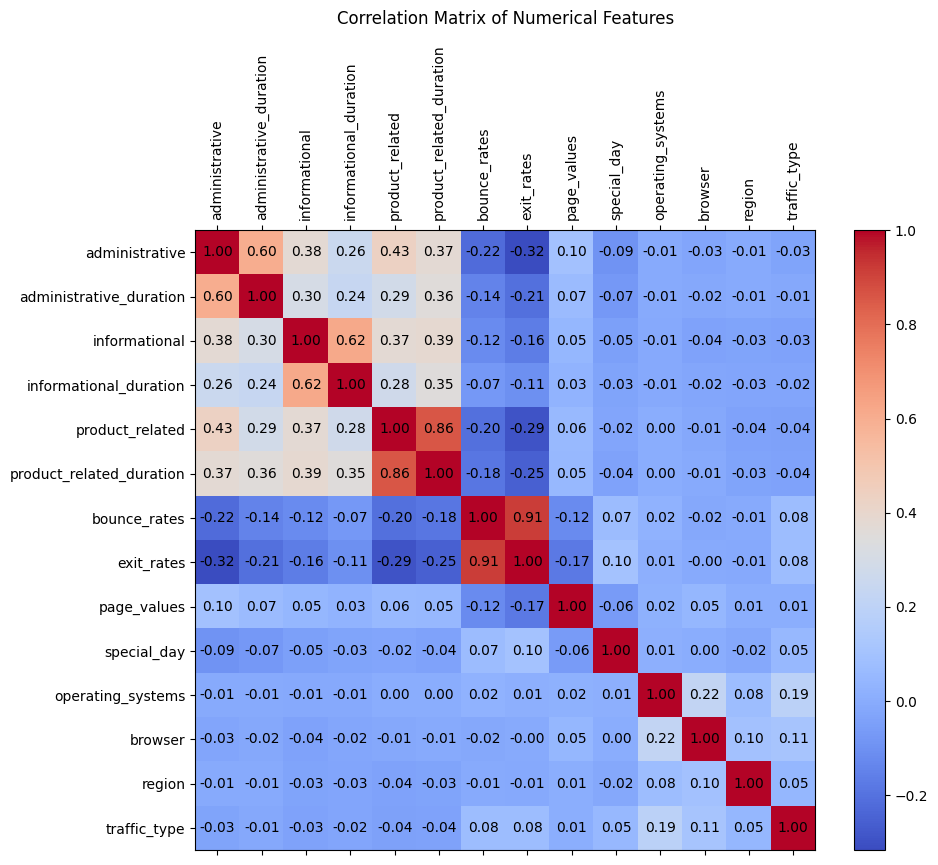

In [16]:
# Step 2: Calculate the correlation matrix
correlation_matrix_temp = data_temp.select_dtypes(include=['number']).corr()

# Optional: Visualise the correlation matrix with annotations using matplotlib
plt.figure(figsize=(10, 8))
plt.matshow(correlation_matrix_temp, cmap='coolwarm', fignum=1)
plt.colorbar()

# Annotate each cell with the correlation value
for (i, j), val in np.ndenumerate(correlation_matrix_temp):
    plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

# Set the ticks and labels
plt.xticks(range(len(correlation_matrix_temp.columns)), correlation_matrix_temp.columns, rotation=90)
plt.yticks(range(len(correlation_matrix_temp.columns)), correlation_matrix_temp.columns)
plt.title('Correlation Matrix of Numerical Features', pad=15)
plt.show()

## Exploratory Data Analysis

Analyse the data to identify 
* patterns
* relationships 
* potential biases

Visualise the data using appropriate techniques including:
* Explore the data to handle
    - Missing values
    - Outliers
    - Inconsistencies
    - Duplicates
    
* Univariate Analysis
    - Categorical Data
    - Numerical Data

* Bivariate / Multivariate Analysis
    - Categorical - Categorical Data
    - Categorical - Numerical Data
    - Numerical - Numerical Data

In [30]:
page_duration_cols = ["administrative_duration","informational_duration", "product_related_duration"]

for cols in page_duration_cols:
    data_raw[cols] = data_raw[cols].replace(0, np.nan)
for cols in page_duration_cols:
    data_raw[cols] = data_raw[cols].replace(-1, np.nan)
for cols in page_duration_cols:
    print('{} null values:'.format(cols),data_raw[cols].isnull().sum(), sep = '\n')

administrative_duration null values:
5903
informational_duration null values:
9925
product_related_duration null values:
755


In [31]:
drop_cols =[]# ['administrative', 'informational', 'product_related', 'exit_rates']

data = (data_raw
        .pipe(rename_columns_to_snake_case)
        .drop_duplicates()
        .assign(special_day=lambda x: (x['special_day'] > 0.4).astype(int),  # Binarize the 'SpecialDay' column
                purchase=lambda x: x['purchase'].astype(int),  # Convert target column to binary
                #**{col: lambda x: label_encoder.fit_transform(x[col]) for col in categorical_features}  # Encode categorical features
               )
        # drop unnecessary columns
        .drop(columns = drop_cols)
        
        # fill missing values with median
        #.fillna({'administrative_duration': data['administrative_duration'].median(), 
        #         'informational_duration': data['informational_duration'].median(),
        #         'product_related_duration': data['product_related_duration'].median(),
        #         })

        # Encoding the categorical features
        #.pipe(pd.get_dummies, columns=categorical_features, drop_first=True, dtype=int)  # Convert categorical features to dummy variables
        .reset_index(drop=True)
        )

In [32]:
# separate the columns into different data dtypes
categorical_cols, numerical_cols, cardinal_cols, nominal_cols = grab_col_names(data)
target_col = 'purchase'

Observations: 12205
Variables: 18
Categorical Columns: 7 -> ['month', 'visitor_type', 'special_day', 'operating_systems', 'region', 'weekend', 'purchase']
Numerical Columns: 11 -> ['administrative', 'administrative_duration', 'informational', 'informational_duration', 'product_related', 'product_related_duration', 'bounce_rates', 'exit_rates', 'page_values', 'browser', 'traffic_type']
Cardinal Columns: 0 -> []
Nominal Columns: 5 -> ['special_day', 'operating_systems', 'region', 'weekend', 'purchase']


In [34]:
# update the categorical features
categorical_features = [col for col in categorical_cols if col not in drop_cols]
numerical_features = [col for col in numerical_cols if col not in drop_cols]

2024-09-13 11:53:23,369 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2024-09-13 11:53:23,377 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


       month      Ratio
month                  
May     3329  27.275707
Nov     2982  24.432610
Mar     1860  15.239656
Dec     1706  13.977878
Oct      549   4.498156
Sep      448   3.670627
Aug      433   3.547726
Jul      432   3.539533
June     285   2.335109
Feb      181   1.482999
##########################################


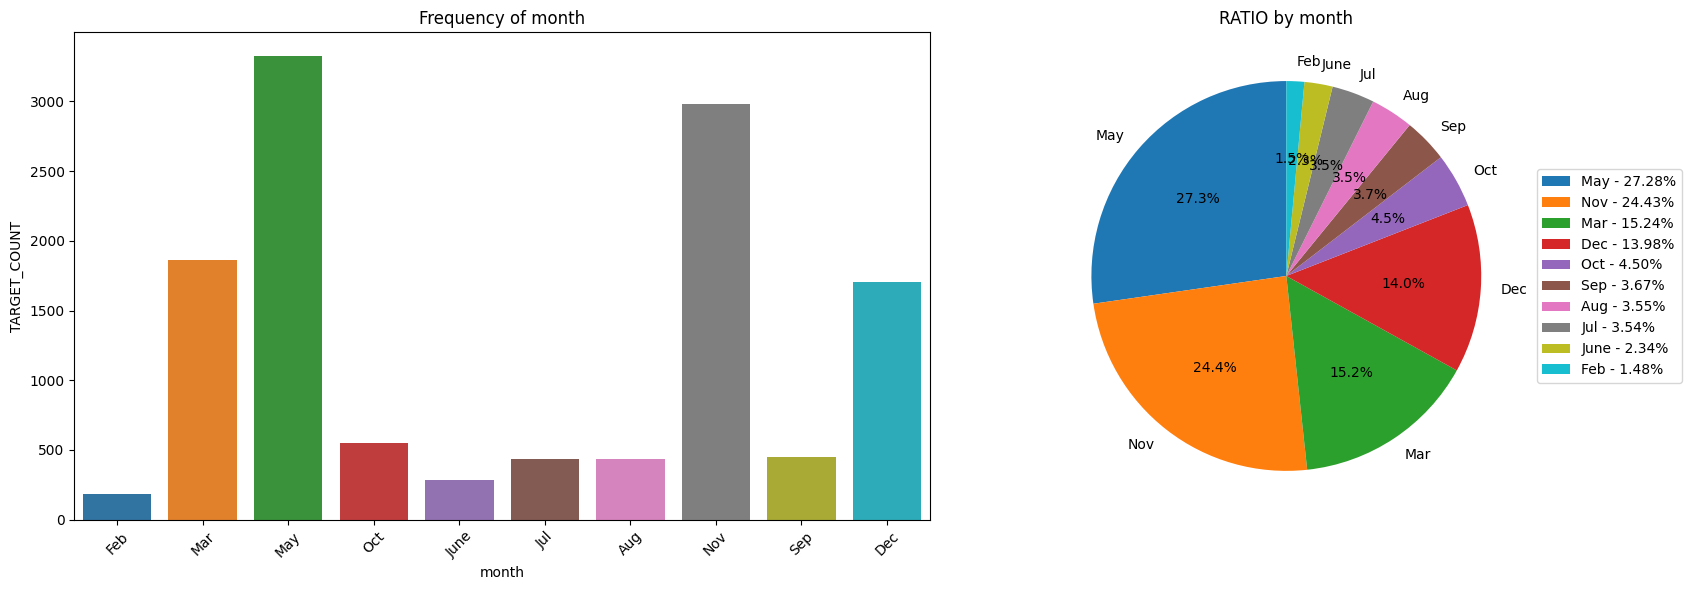

                   visitor_type      Ratio
visitor_type                              
Returning_Visitor         10431  85.464973
New_Visitor                1693  13.871364
Other                        81   0.663662
##########################################


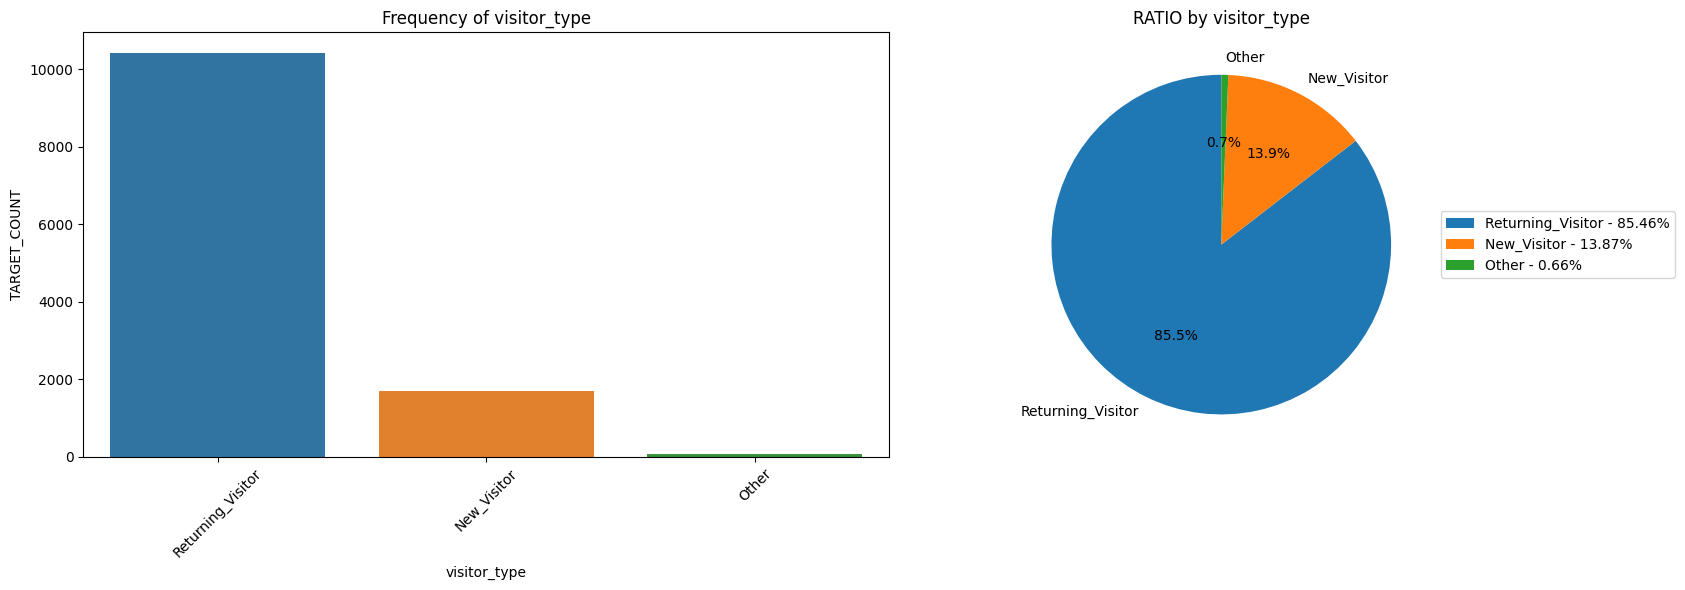

2024-09-13 11:53:23,725 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-13 11:53:23,732 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


             special_day      Ratio
special_day                        
0                  11377  93.215895
1                    828   6.784105
##########################################


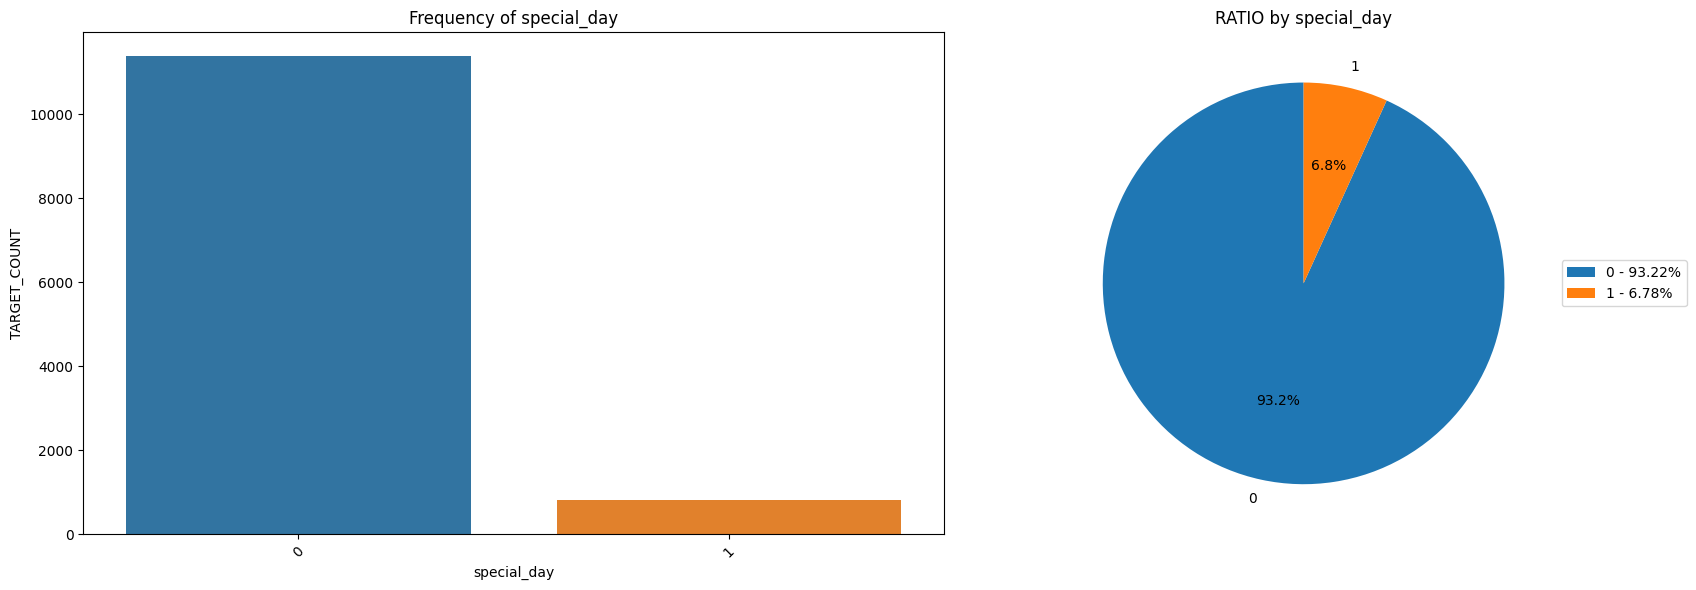

2024-09-13 11:53:23,872 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-13 11:53:23,880 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


                   operating_systems      Ratio
operating_systems                              
2                               6541  53.592790
1                               2549  20.884883
3                               2530  20.729209
4                                478   3.916428
8                                 75   0.614502
6                                 19   0.155674
7                                  7   0.057354
5                                  6   0.049160
##########################################


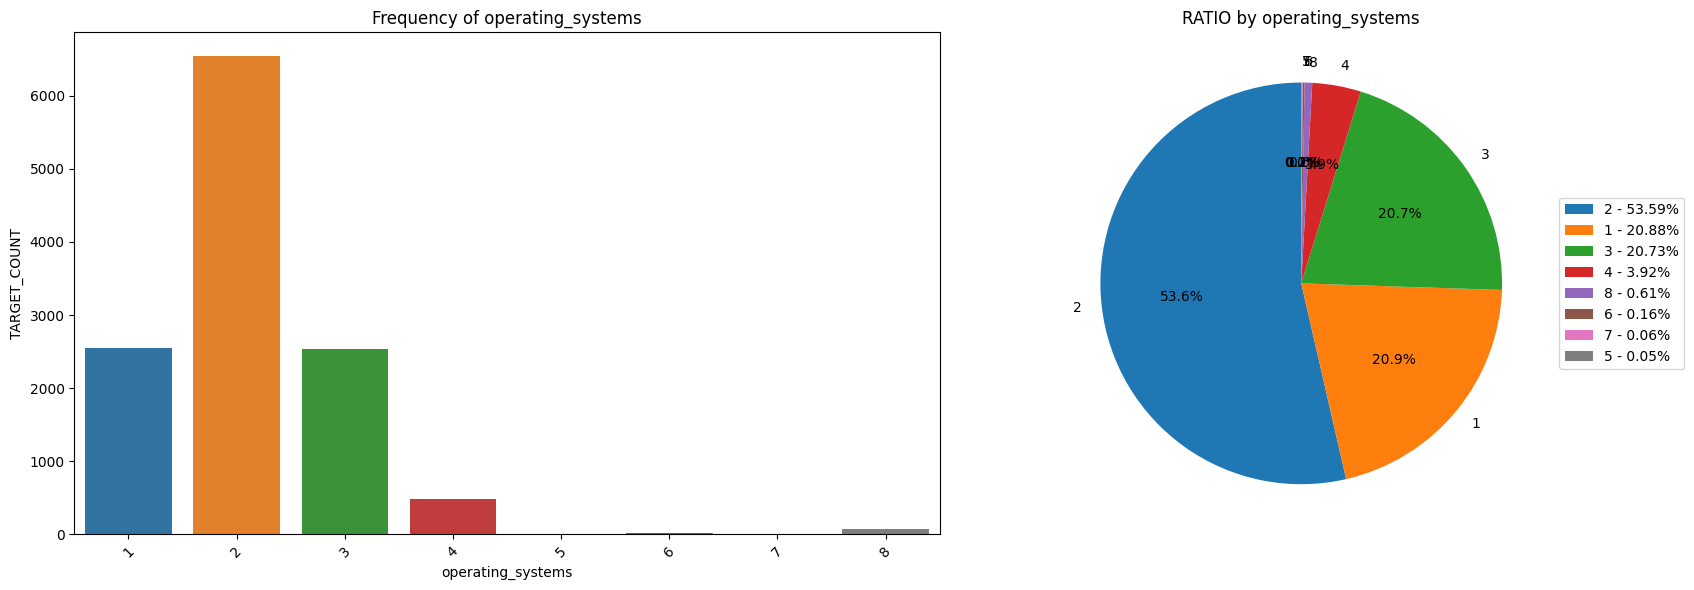

2024-09-13 11:53:24,060 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


        region      Ratio
region                   
1         4714  38.623515
3         2379  19.492011
4         1171   9.594429
2         1128   9.242114
6          801   6.562884
7          758   6.210569
9          505   4.137649
8          431   3.531340
5          318   2.605490
##########################################


2024-09-13 11:53:24,068 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


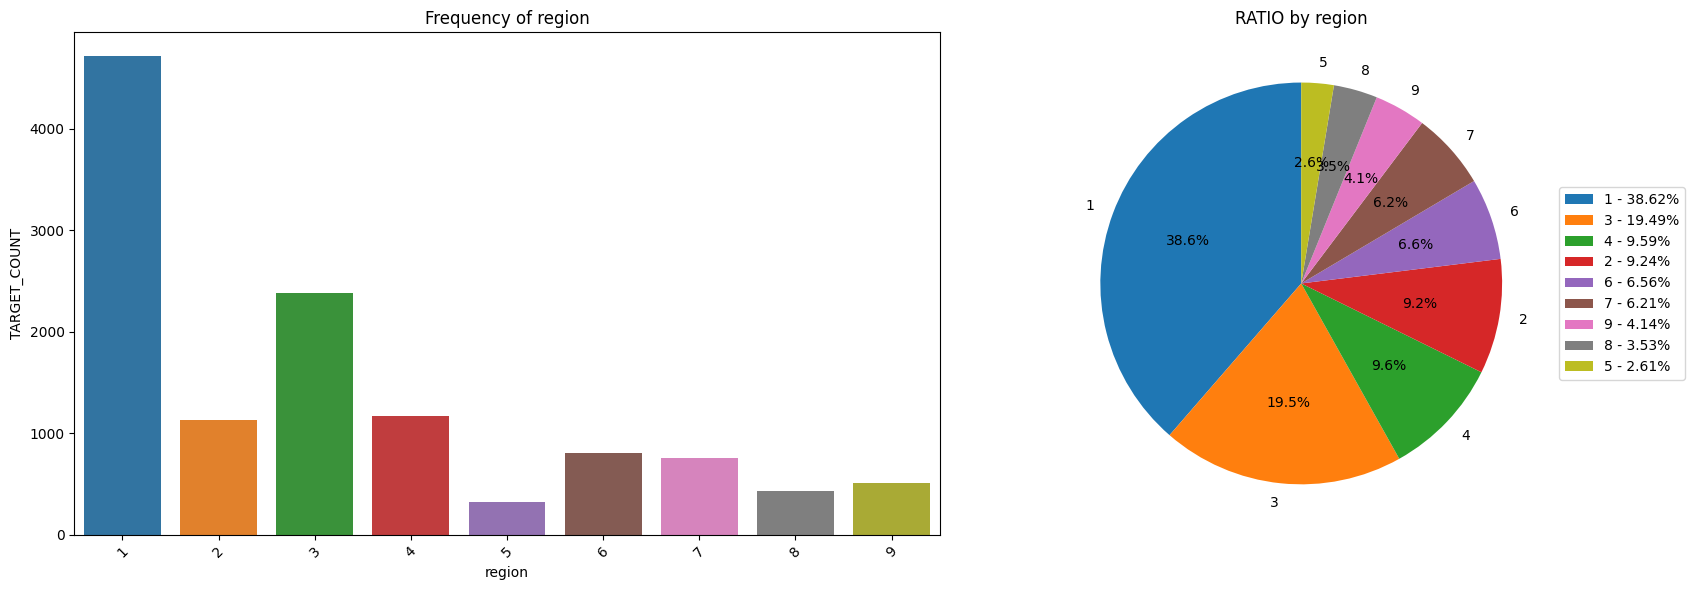

2024-09-13 11:53:24,276 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-13 11:53:24,287 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


         weekend      Ratio
weekend                    
0           9346  76.575174
1           2859  23.424826
##########################################


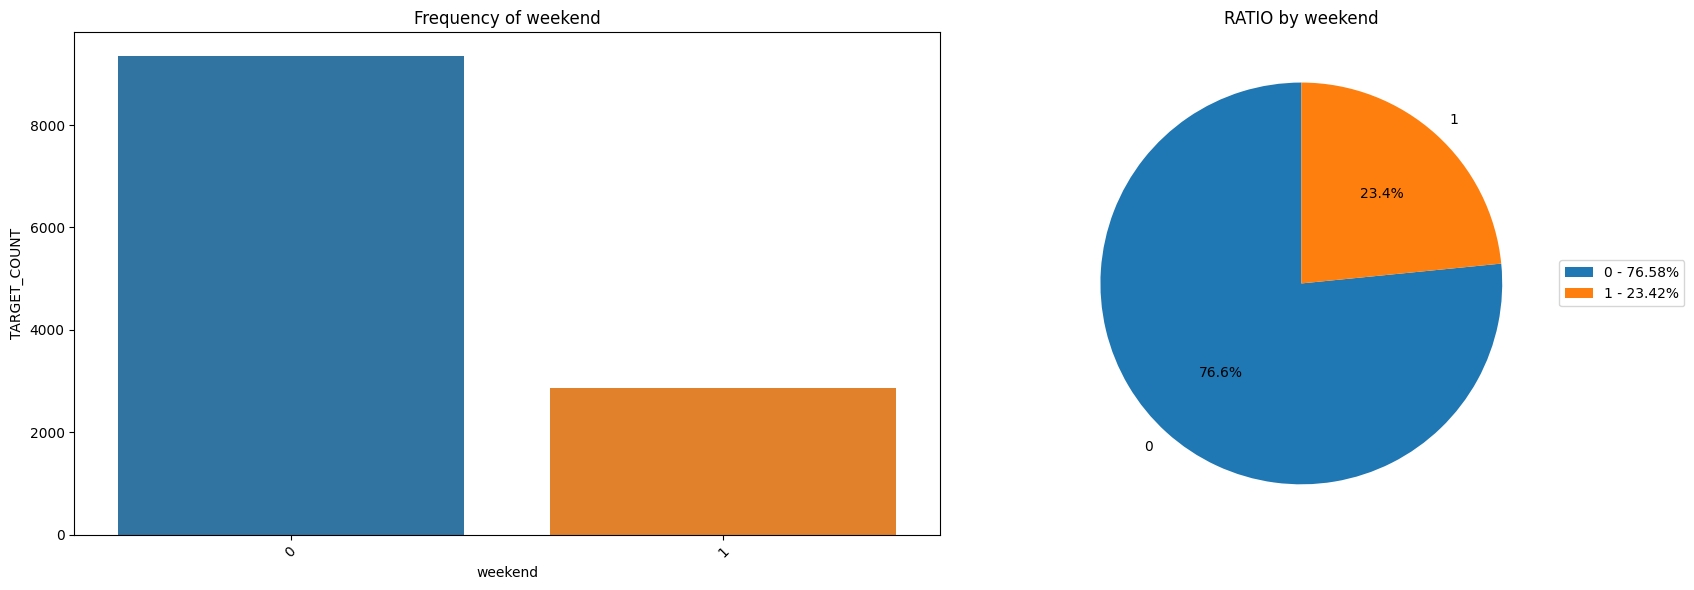

          purchase      Ratio
purchase                     
0            10297  84.367063
1             1908  15.632937
##########################################


2024-09-13 11:53:24,476 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-13 11:53:24,483 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


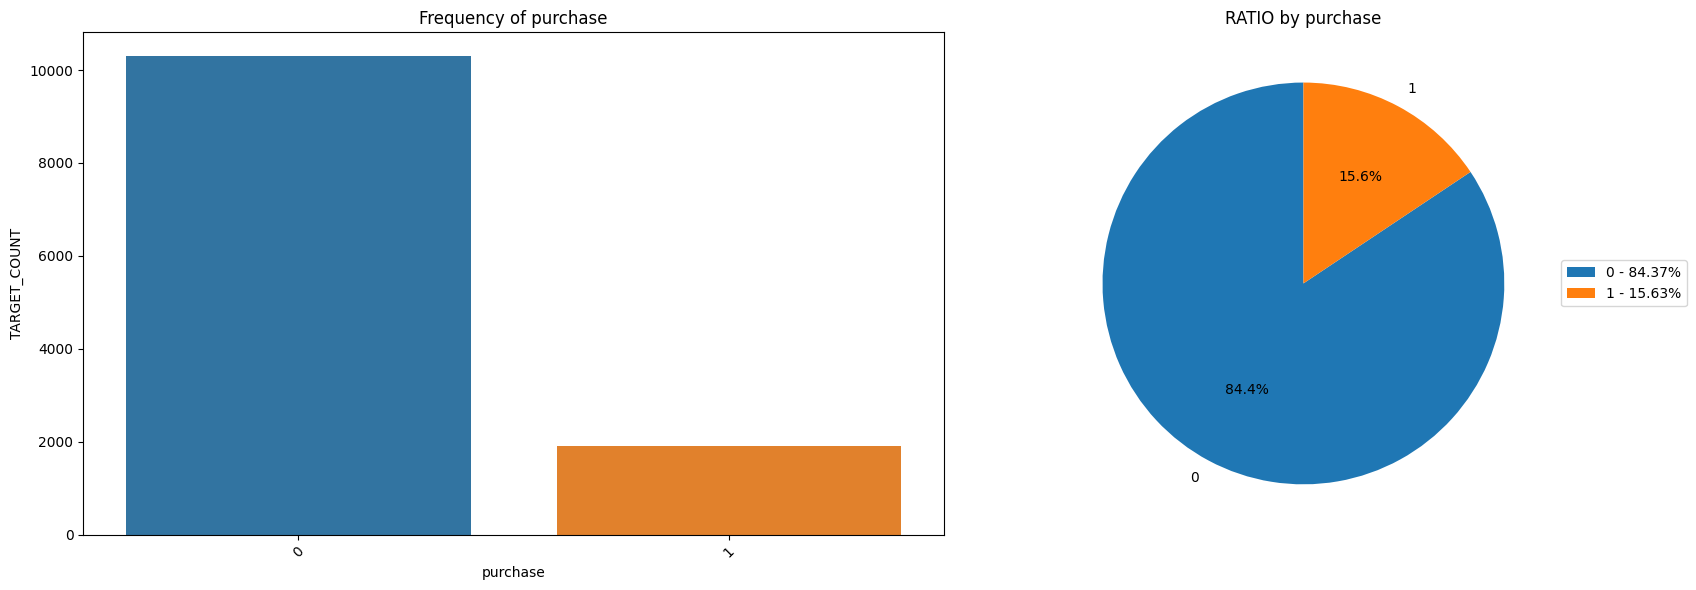

In [35]:
# Examination of categorical variables

for col in categorical_cols:
    cat_summary(data, col,plot=True)

In [28]:
data[numerical_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
administrative,12205.0,2.338878,3.330436,0.0,0.000000,1.000000,4.000000,27.000000
administrative_duration,12205.0,81.646331,177.491845,0.0,0.000000,9.000000,94.700000,3398.750000
informational,12205.0,0.508726,1.275617,0.0,0.000000,0.000000,0.000000,24.000000
informational_duration,12205.0,34.825454,141.424807,0.0,0.000000,0.000000,0.000000,2549.375000
product_related,12205.0,32.045637,44.593649,0.0,8.000000,18.000000,38.000000,705.000000
product_related_duration,12205.0,1206.982457,1919.601400,0.0,193.000000,608.942857,1477.154762,63973.522230
bounce_rates,12205.0,0.020370,0.045255,0.0,0.000000,0.002899,0.016667,0.200000
exit_rates,12205.0,0.041466,0.046163,0.0,0.014231,0.025000,0.048529,0.200000
page_values,12205.0,5.949574,18.653671,0.0,0.000000,0.000000,0.000000,361.763742
browser,12205.0,2.357804,1.710114,1.0,2.000000,2.000000,2.000000,13.000000


Numerical Column: administrative
##########################################
count    12205.000000
mean         2.338878
std          3.330436
min          0.000000
5%           0.000000
10%          0.000000
20%          0.000000
30%          0.000000
40%          0.000000
50%          1.000000
60%          2.000000
70%          3.000000
80%          4.000000
90%          7.000000
95%          9.000000
99%         14.000000
max         27.000000
Name: administrative, dtype: float64
##########################################


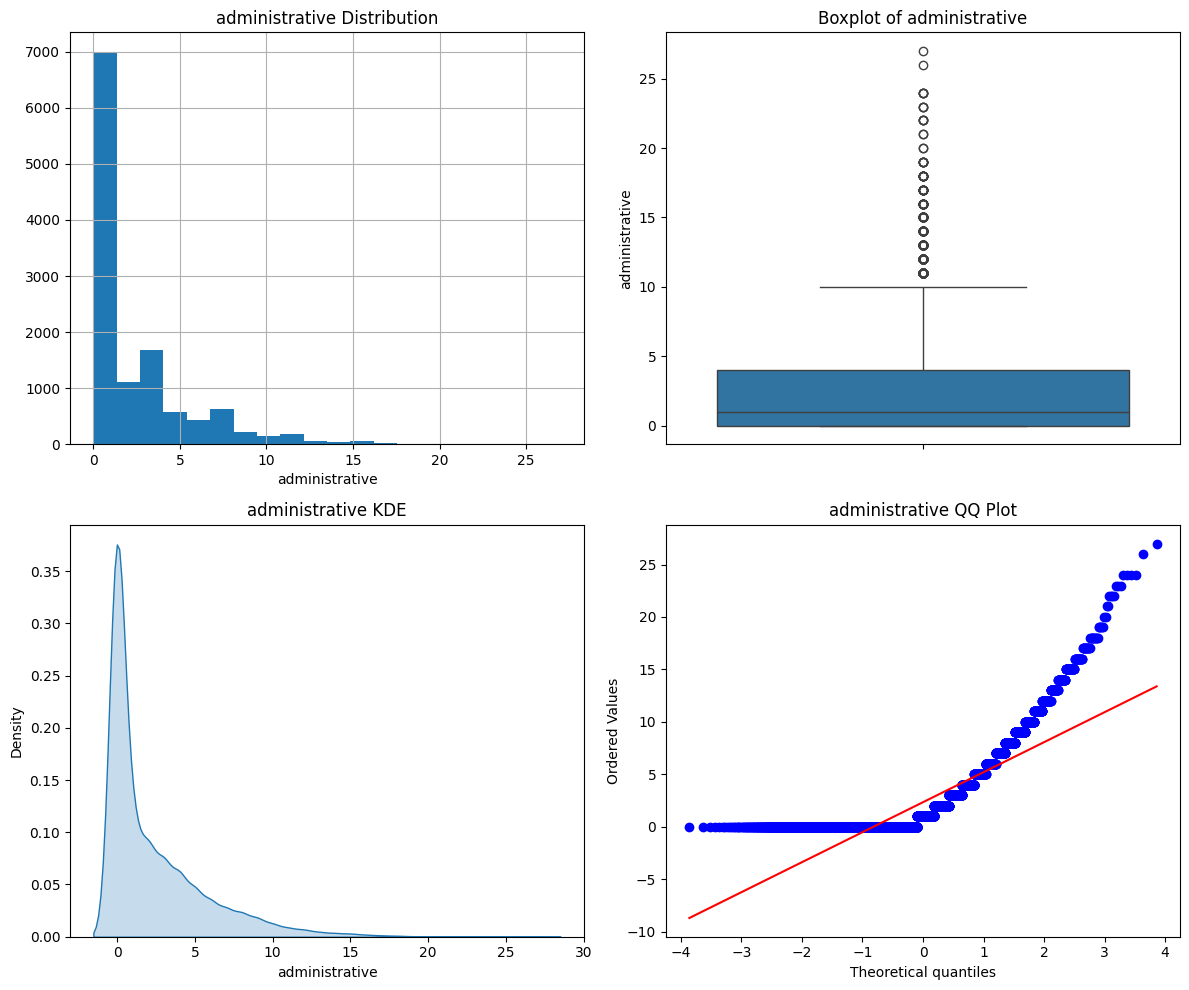

Numerical Column: administrative_duration
##########################################
count    12205.000000
mean        81.646331
std        177.491845
min          0.000000
5%           0.000000
10%          0.000000
20%          0.000000
30%          0.000000
40%          0.000000
50%          9.000000
60%         38.000000
70%         72.558667
80%        123.000000
90%        227.000000
95%        352.208095
99%        838.704889
max       3398.750000
Name: administrative_duration, dtype: float64
##########################################


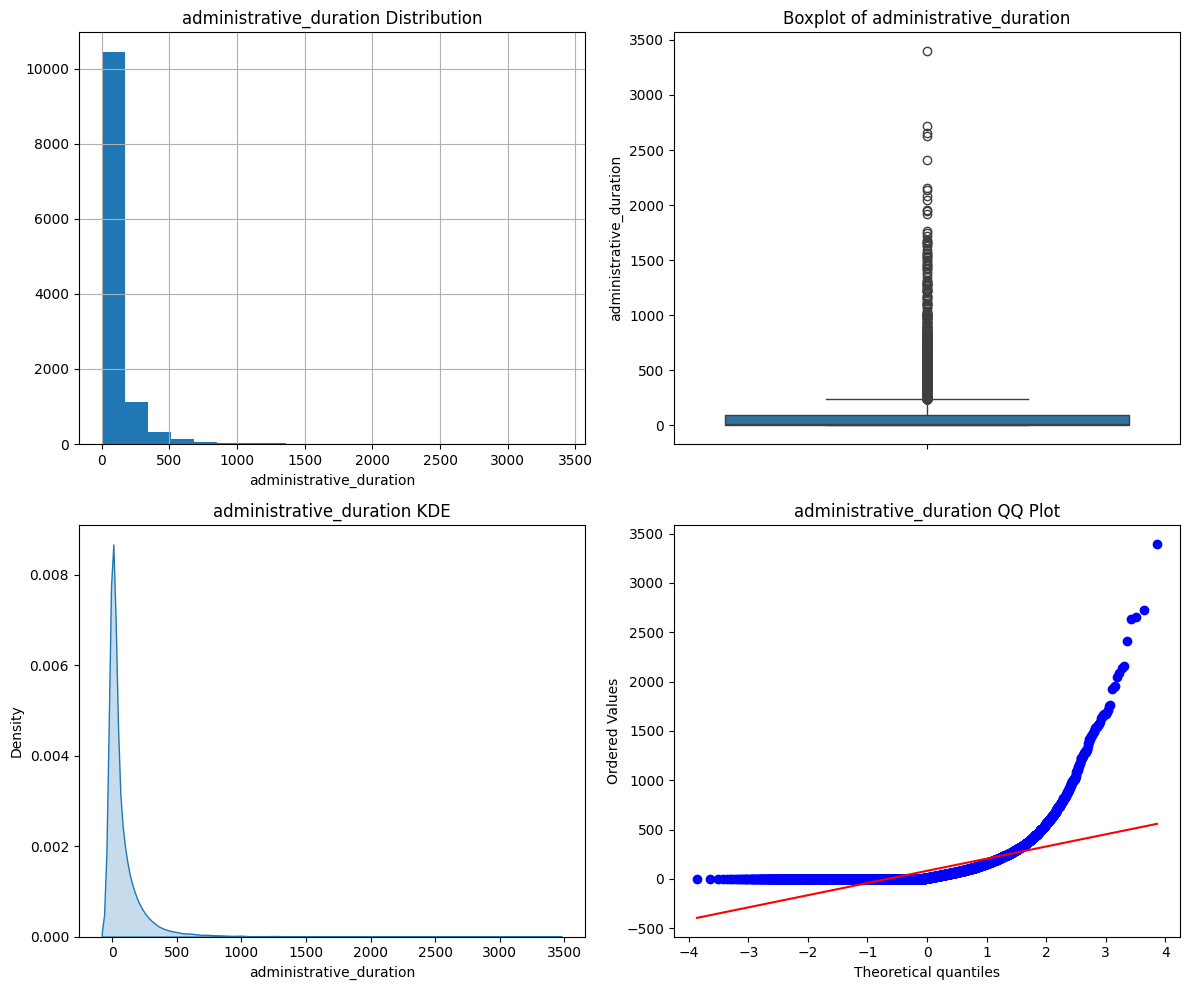

Numerical Column: informational
##########################################
count    12205.000000
mean         0.508726
std          1.275617
min          0.000000
5%           0.000000
10%          0.000000
20%          0.000000
30%          0.000000
40%          0.000000
50%          0.000000
60%          0.000000
70%          0.000000
80%          1.000000
90%          2.000000
95%          3.000000
99%          6.000000
max         24.000000
Name: informational, dtype: float64
##########################################


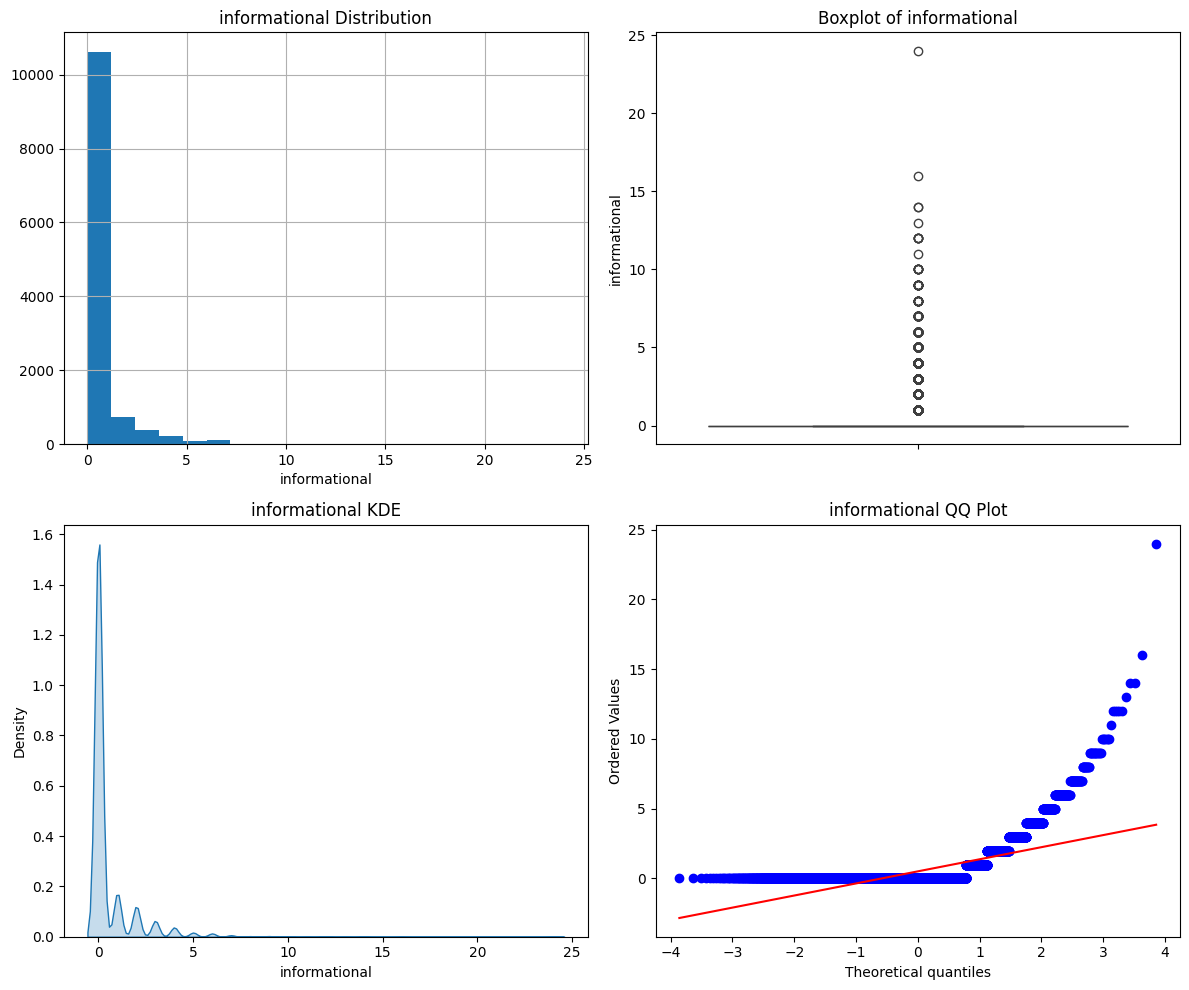

Numerical Column: informational_duration
##########################################
count    12205.000000
mean        34.825454
std        141.424807
min          0.000000
5%           0.000000
10%          0.000000
20%          0.000000
30%          0.000000
40%          0.000000
50%          0.000000
60%          0.000000
70%          0.000000
80%          0.000000
90%         73.900000
95%        199.000000
99%        722.379200
max       2549.375000
Name: informational_duration, dtype: float64
##########################################


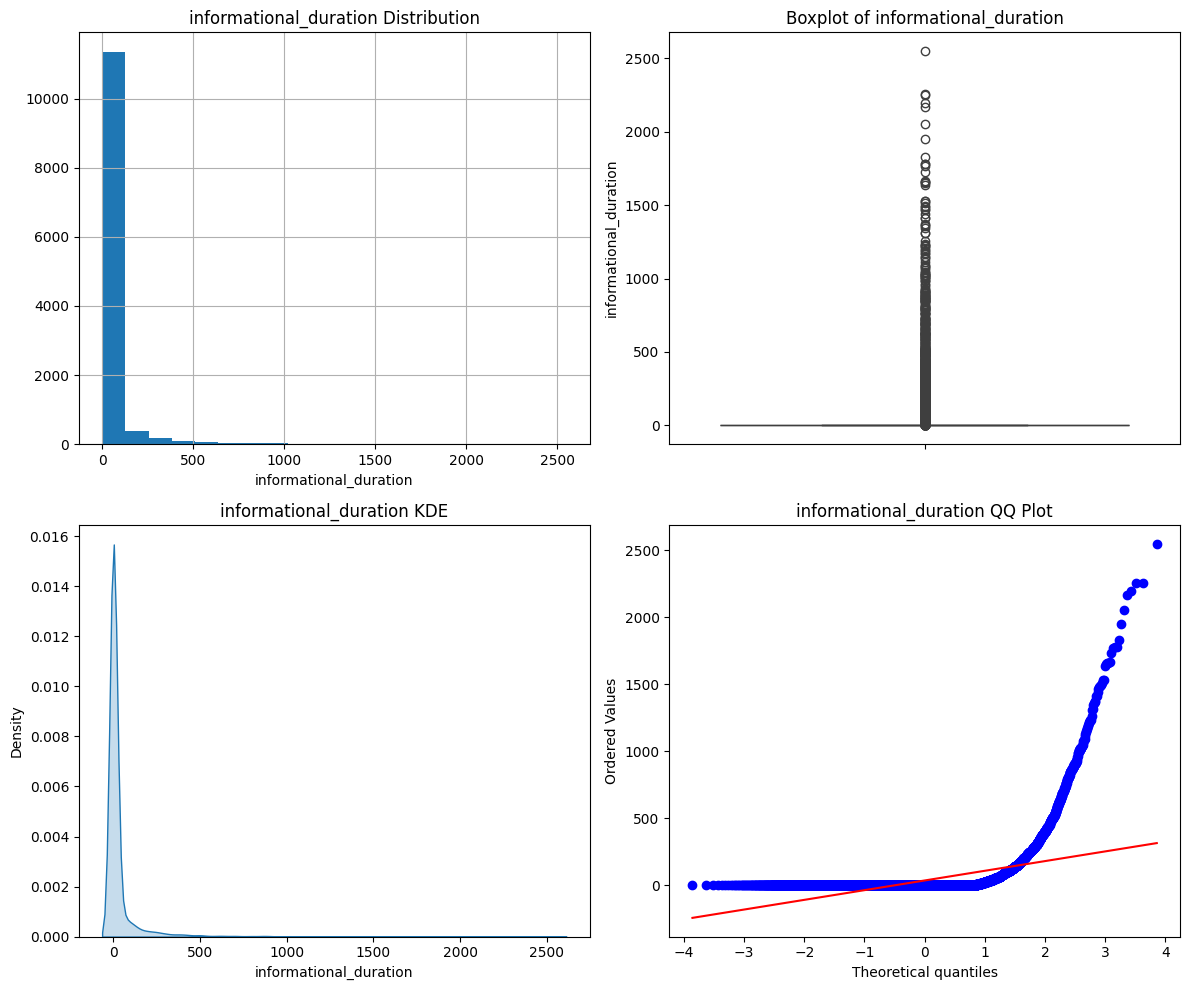

Numerical Column: product_related
##########################################
count    12205.000000
mean        32.045637
std         44.593649
min          0.000000
5%           2.000000
10%          3.000000
20%          6.000000
30%          9.000000
40%         13.000000
50%         18.000000
60%         24.000000
70%         32.000000
80%         46.000000
90%         74.000000
95%        110.000000
99%        221.000000
max        705.000000
Name: product_related, dtype: float64
##########################################


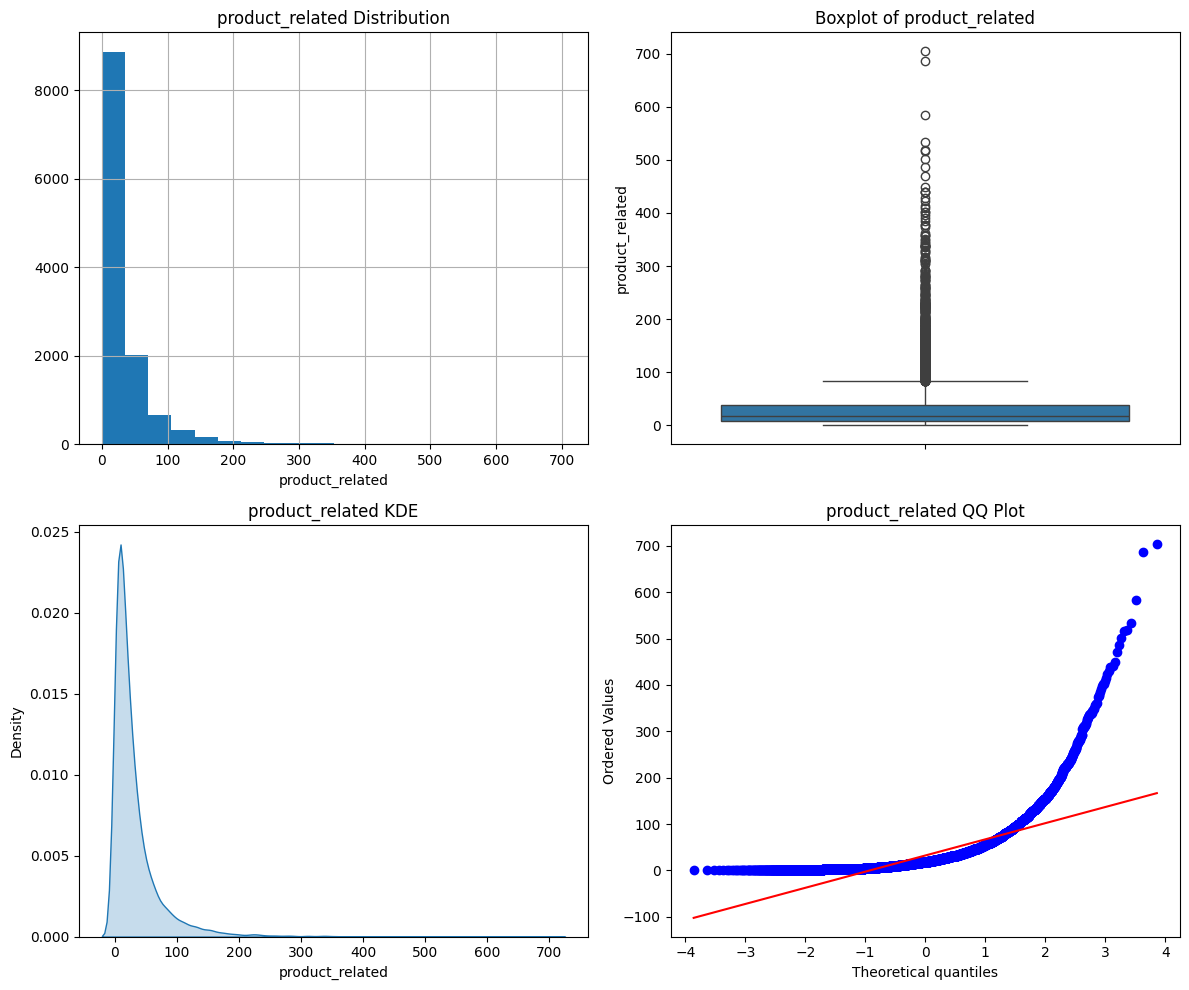

Numerical Column: product_related_duration
##########################################
count    12205.000000
mean      1206.982457
std       1919.601400
min          0.000000
5%           0.000000
10%         44.500000
20%        137.000000
30%        257.213333
40%        413.000000
50%        608.942857
60%        865.884286
70%       1239.859682
80%       1792.802896
90%       2904.459143
95%       4312.956282
99%       8704.271573
max      63973.522230
Name: product_related_duration, dtype: float64
##########################################


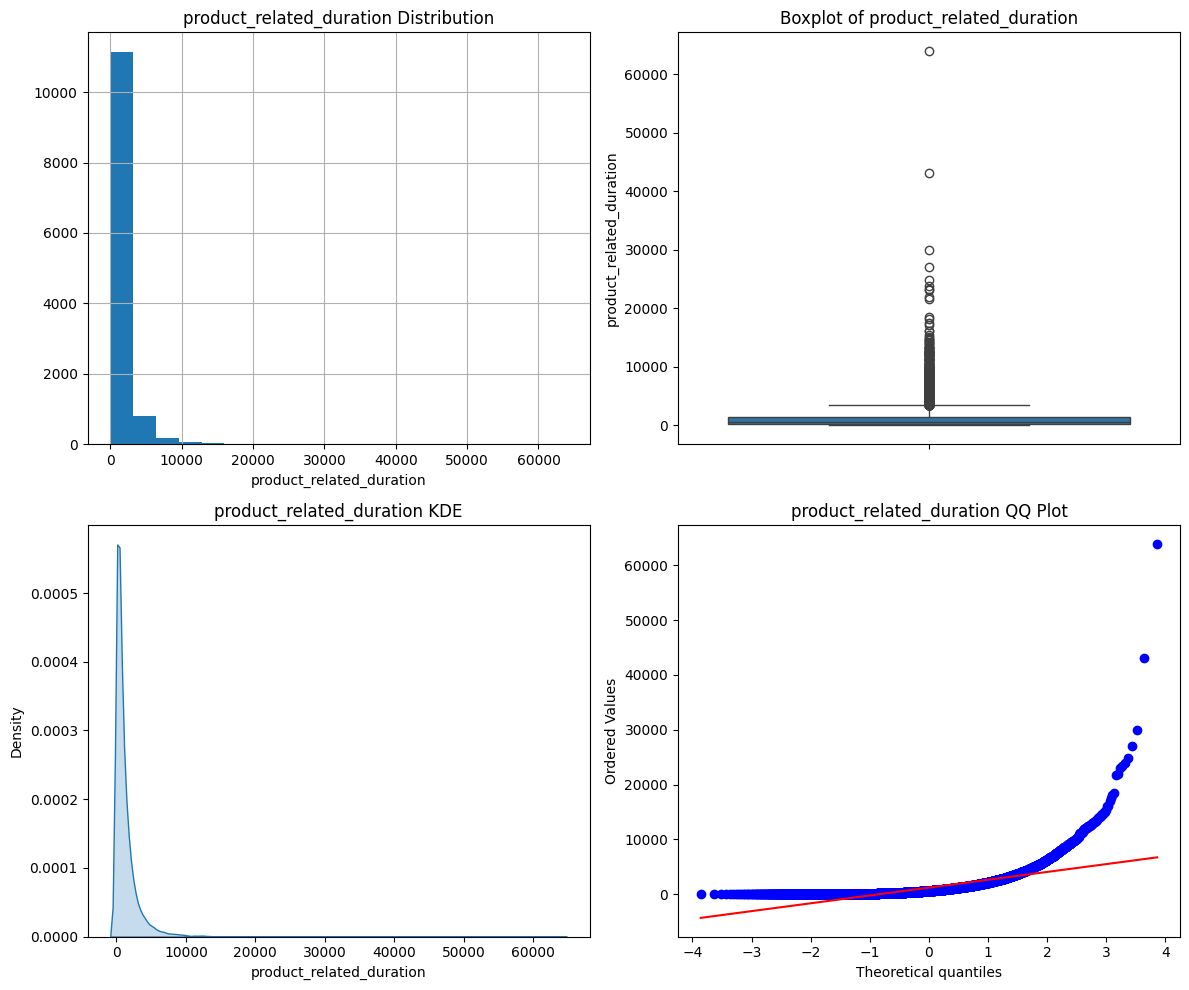

Numerical Column: bounce_rates
##########################################
count    12205.000000
mean         0.020370
std          0.045255
min          0.000000
5%           0.000000
10%          0.000000
20%          0.000000
30%          0.000000
40%          0.000000
50%          0.002899
60%          0.006838
70%          0.012500
80%          0.022222
90%          0.050000
95%          0.149333
99%          0.200000
max          0.200000
Name: bounce_rates, dtype: float64
##########################################


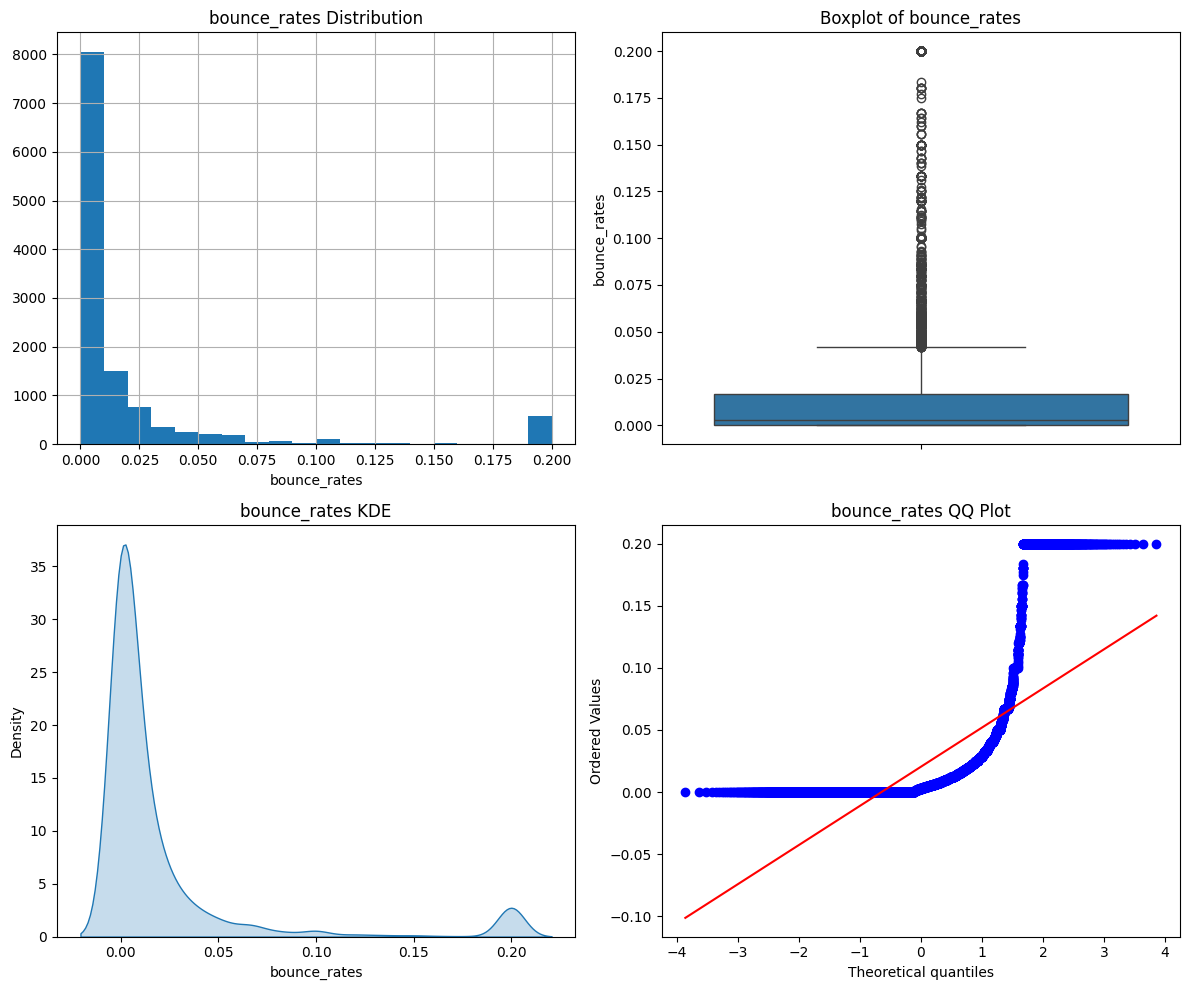

Numerical Column: exit_rates
##########################################
count    12205.000000
mean         0.041466
std          0.046163
min          0.000000
5%           0.004545
10%          0.007407
20%          0.011965
30%          0.016008
40%          0.020290
50%          0.025000
60%          0.032019
70%          0.040000
80%          0.056425
90%          0.100000
95%          0.173714
99%          0.200000
max          0.200000
Name: exit_rates, dtype: float64
##########################################


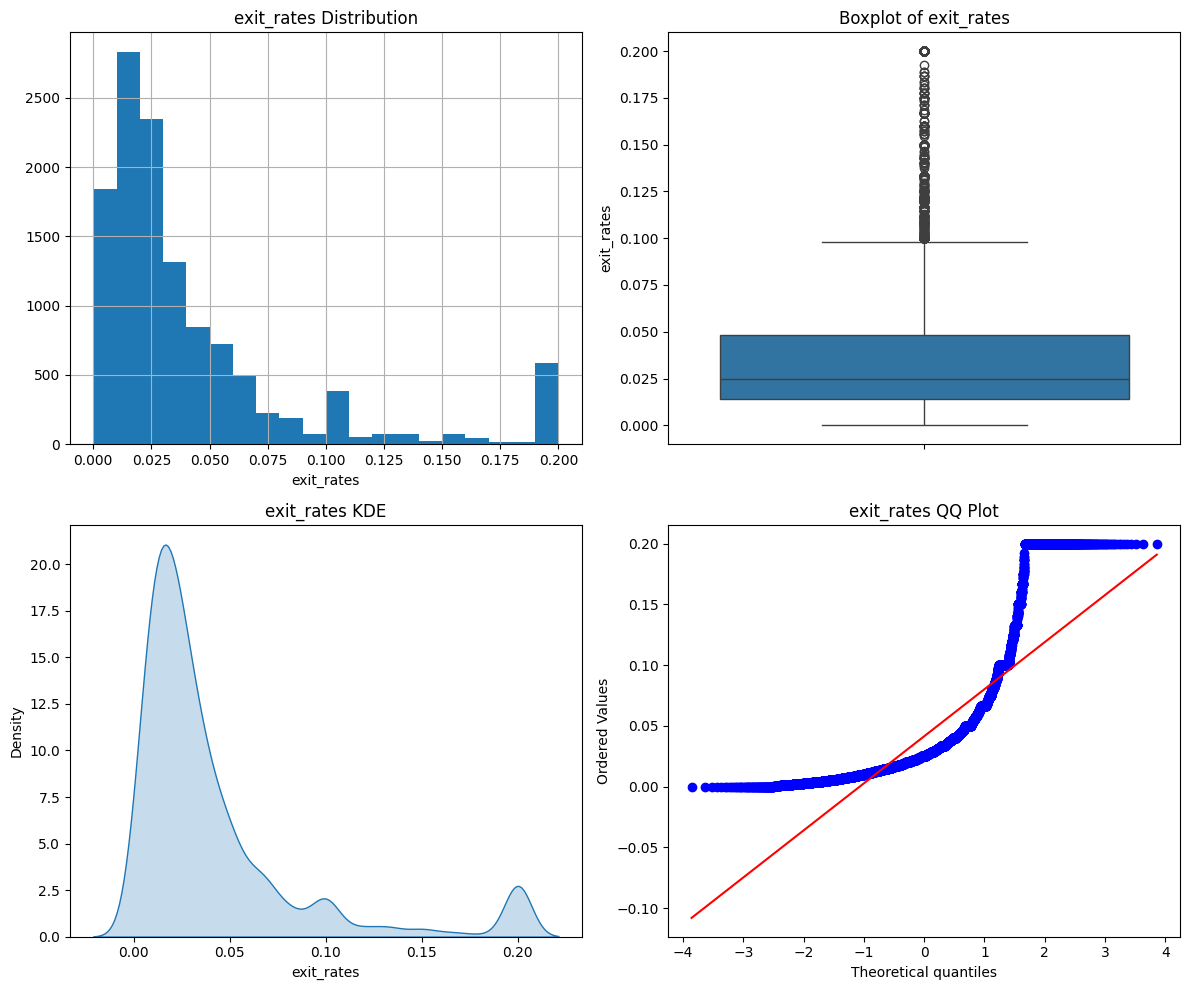

Numerical Column: page_values
##########################################
count    12205.000000
mean         5.949574
std         18.653671
min          0.000000
5%           0.000000
10%          0.000000
20%          0.000000
30%          0.000000
40%          0.000000
50%          0.000000
60%          0.000000
70%          0.000000
80%          3.299556
90%         19.114139
95%         38.301457
99%         86.108689
max        361.763742
Name: page_values, dtype: float64
##########################################


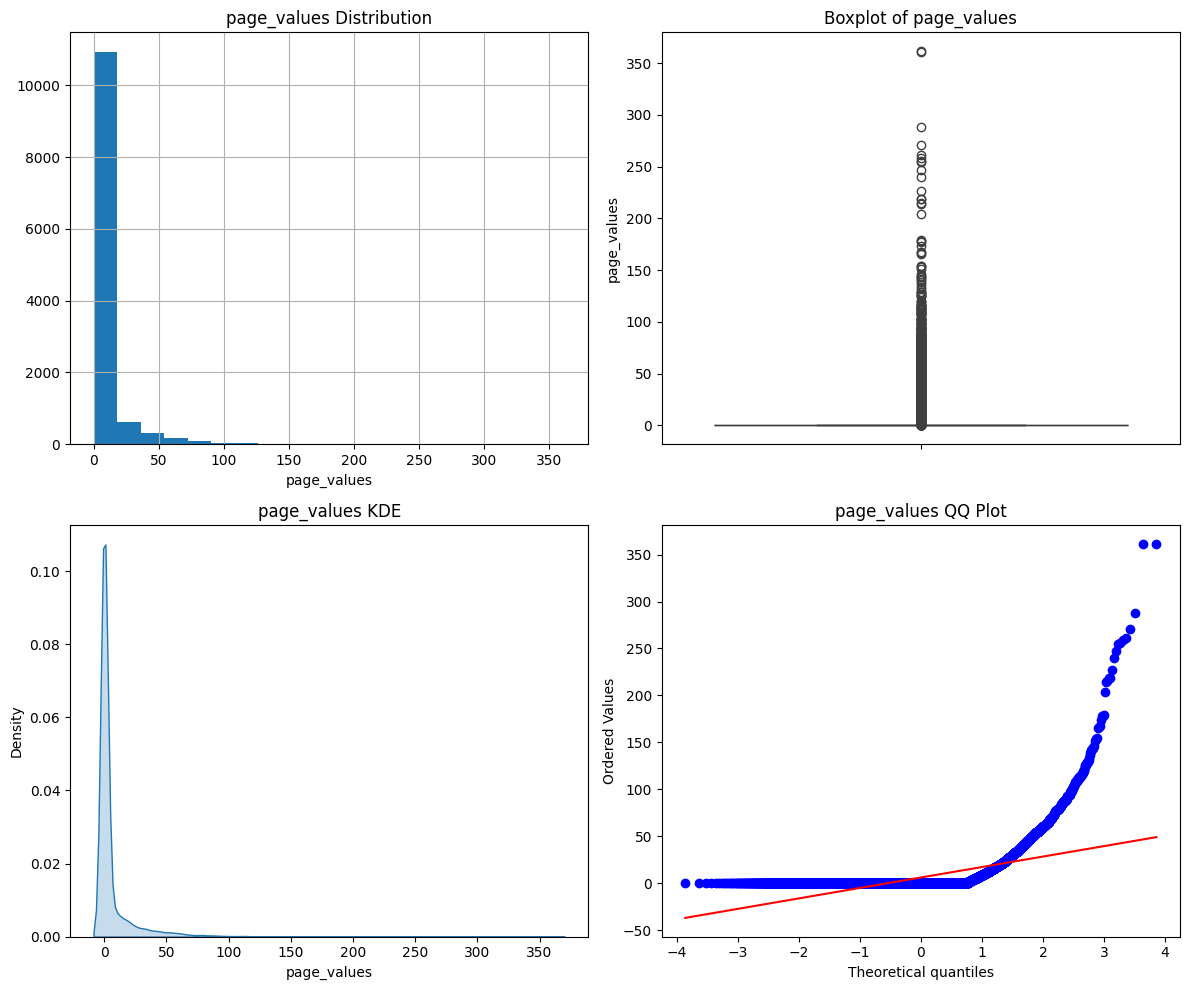

Numerical Column: browser
##########################################
count    12205.000000
mean         2.357804
std          1.710114
min          1.000000
5%           1.000000
10%          1.000000
20%          2.000000
30%          2.000000
40%          2.000000
50%          2.000000
60%          2.000000
70%          2.000000
80%          2.000000
90%          4.000000
95%          5.000000
99%         10.000000
max         13.000000
Name: browser, dtype: float64
##########################################


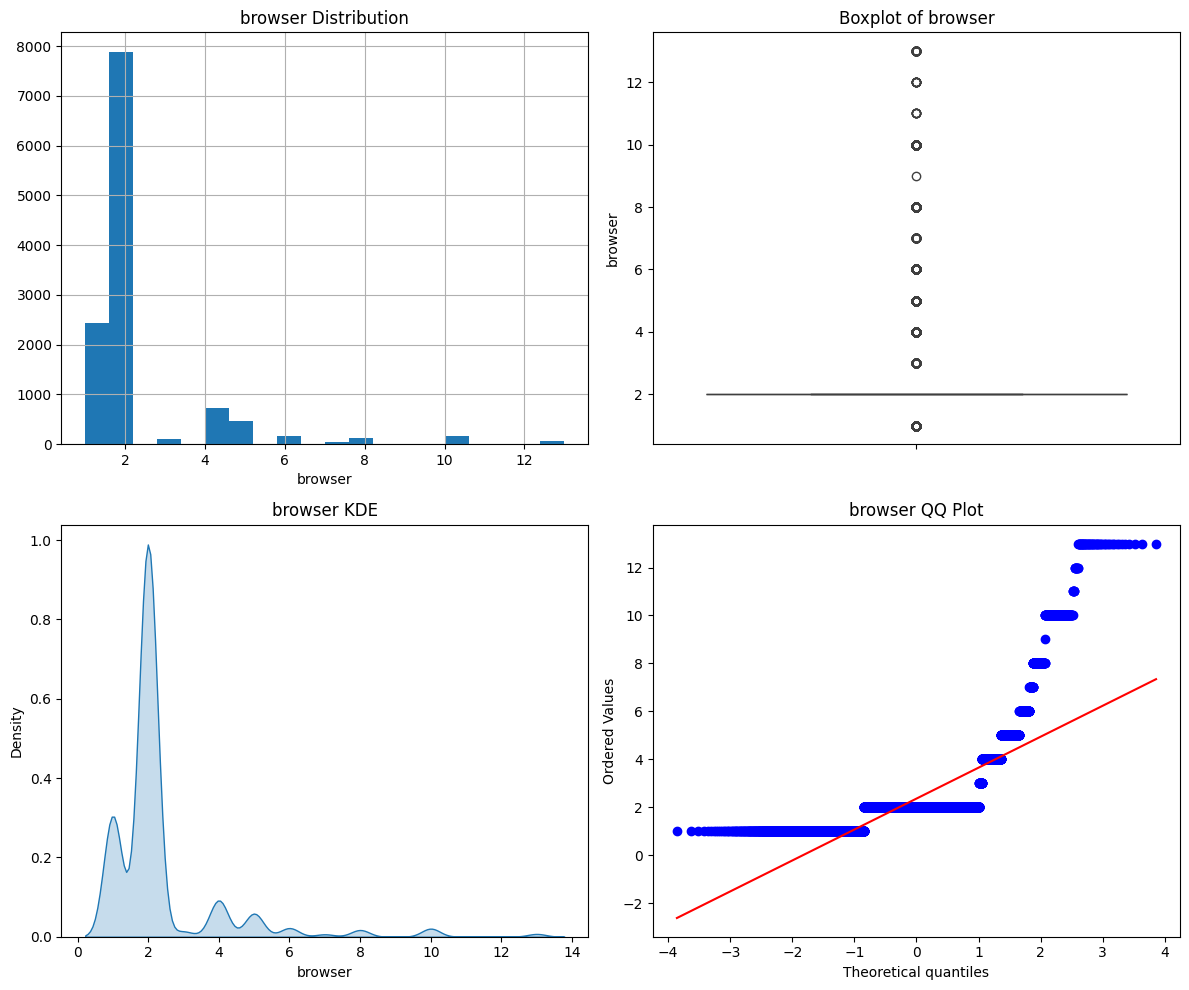

Numerical Column: traffic_type
##########################################
count    12205.000000
mean         4.073904
std          4.016654
min          1.000000
5%           1.000000
10%          1.000000
20%          2.000000
30%          2.000000
40%          2.000000
50%          2.000000
60%          3.000000
70%          4.000000
80%          6.000000
90%         11.000000
95%         13.000000
99%         20.000000
max         20.000000
Name: traffic_type, dtype: float64
##########################################


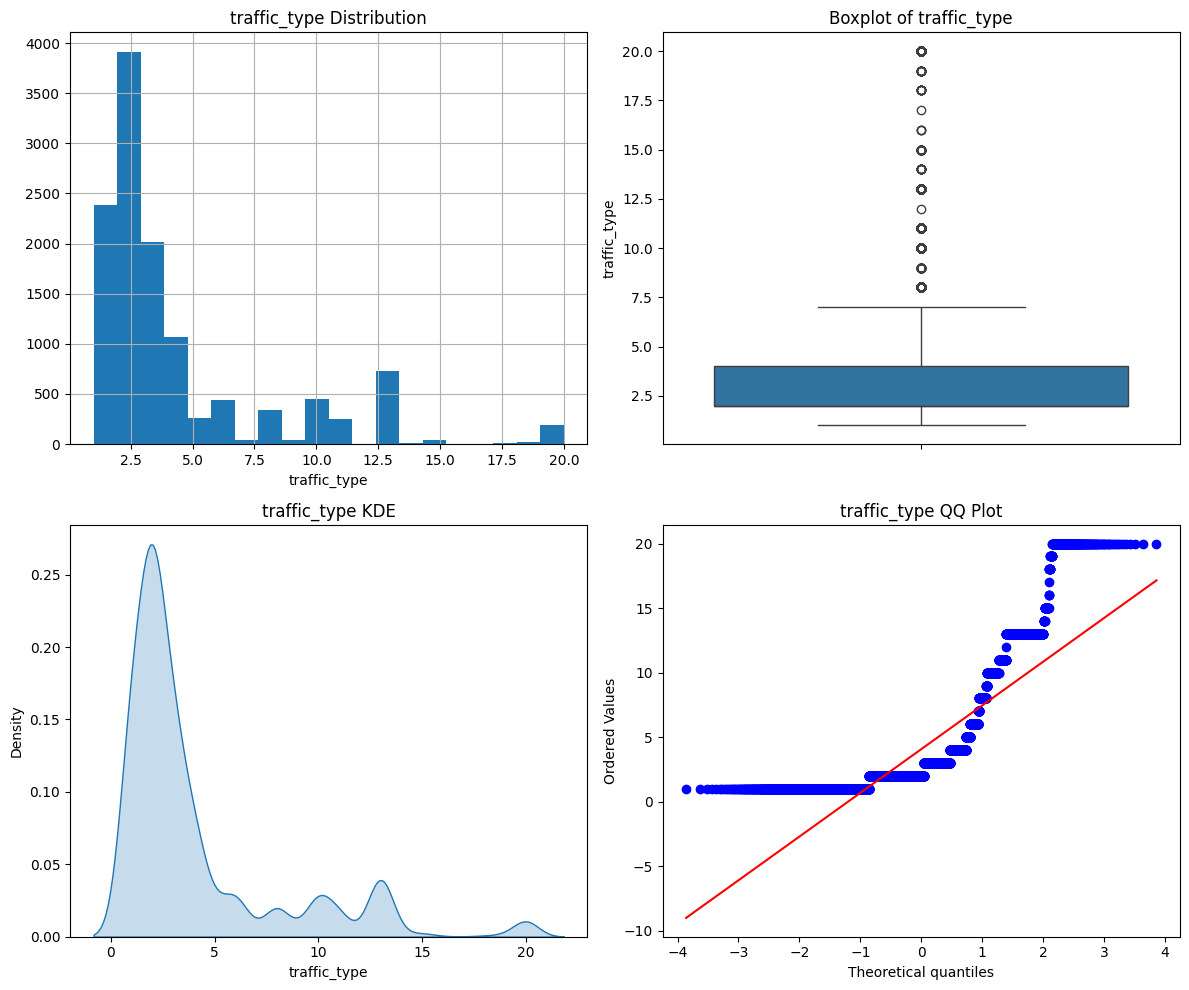

In [29]:
for col in numerical_cols:
    num_summary(dataframe=data,
                numerical_col= col,
                plot= True)

## 3.2 Model Training Evaluation

* Split the data into training and testing sets.
* Train the model on the training set and 
* Evaluate its performance on the testing set using metrics like accuracy, precision, recall, F1-score, and AUC ROC.

In [36]:

# Parameters
use_other_modules = True
stratify_target = True

test_size = 0.2
param_grid_flag = False
scoring_metric = "accuracy"
stratify_target = False

In [37]:
# Split data into features and target

X = data.drop(columns=[target_col])
y = data[target_col]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

print(f"{X_train.shape=}")
print(f"{y_train.shape=}")
print(f"{X_test.shape=}")

X_train.shape=(9764, 17)
y_train.shape=(9764,)
X_test.shape=(2441, 17)


In [39]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix
    )
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import cross_val_score

In [41]:
def train_and_evaluate_classifiers(X, y, classifiers, test_size=0.2, random_state=42, cv=5, 
                                   grid_search_params=None, use_cross_validation=True, 
                                   use_grid_search=False, use_imbalance_handling=False, 
                                   save_preprocessor=True, return_best_model=True):
    """
    Trains and evaluates multiple classifiers on a given dataset.
    
    Args:
        X (pd.DataFrame): Feature matrix.
        y (pd.Series): Target vector.
        classifiers (dict): A dictionary of classifier names and their respective class instances.
        test_size (float): Proportion of data to use for testing.
        random_state (int): Random seed for reproducibility.
        cv (int): Number of folds for cross-validation.
        grid_search_params (dict): A dictionary of grid search parameters for each classifier (optional).
        use_cross_validation (bool): If True, perform cross-validation.
        use_grid_search (bool): If True, perform grid search for hyperparameter optimisation.
        use_imbalance_handling (bool): If True, apply SMOTE and RandomUnderSampler for imbalance handling.
        save_preprocessor (bool): If True, save the preprocessor to a file.
        return_best_model (bool): If True, return the best model.

    Returns:
        pd.DataFrame: A DataFrame of evaluation results.
        pipeline: The best model's pipeline (if return_best_model is True).
        dict: A dictionary of the trained models.
    """

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Preprocessing pipelines
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])      

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features),
            ('num', numerical_transformer, numeric_features)
        ])
    
    # Get the all the feature names for feature importance analysis
    all_feature_names = pd.DataFrame(preprocessor.fit_transform(X_train), 
                            columns=preprocessor.get_feature_names_out(), 
                            index=X_train.index)
    feature_names = all_feature_names.columns.tolist()
    
    # Optionally handle class imbalance using SMOTE and RandomUnderSampler
    if use_imbalance_handling:
        oversample = SMOTE(k_neighbors=3, sampling_strategy=0.3, random_state=random_state)
        undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=random_state)
    
    # Train and evaluate each classifier
    results = []
    best_model = None
    best_models = {}
    best_score = 0

    classifer_results = {}
    
    for classifier_name, classifier in classifiers.items():
        print(f"\nTraining {classifier_name}...")
        
        # Build pipeline
        if use_imbalance_handling:
            steps = [('preprocessor', preprocessor), ('over', oversample), ('under', undersample), ('classifier', classifier)]
            pipeline = ImbPipeline(steps=steps)
        else:
            steps = [('preprocessor', preprocessor), ('classifier', classifier)]
            pipeline = Pipeline(steps=steps)
        
        # Cross-validation or Grid Search
        start_time = time.time()
        if use_grid_search and grid_search_params and classifier_name in grid_search_params:
            print(f"Optimising {classifier_name} with GridSearchCV...")
            grid_search = GridSearchCV(pipeline, grid_search_params[classifier_name], cv=cv, scoring='f1')
            grid_search.fit(X_train, y_train)
            pipeline = grid_search.best_estimator_  # Use the best estimator from GridSearchCV
            fit_time = time.time() - start_time
            cv_scores = None  # No need for separate cross-validation scores when grid search is used
            best_estimator = pipeline
        
        elif use_cross_validation:
            print(f"Performing Cross-Validation for {classifier_name}...")
            cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')
            fit_time = time.time() - start_time
            best_estimator = pipeline
            pipeline.fit(X_train, y_train)
        else:
            print(f"Fitting {classifier_name} without Cross-Validation...")
            best_estimator = pipeline
            pipeline.fit(X_train, y_train)
            fit_time = time.time() - start_time
            cv_scores = None  # No cross-validation scores in this case

        # Evaluate on the test set
        y_pred = pipeline.predict(X_test)

        # Get predicted probabilities
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        # Generate confusion matrix
        confusion_mat = confusion_matrix(y_test, y_pred)

        # Append evaluation results
        results.append({
            'Classifier': classifier_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC AUC': roc_auc,
            'CV F1-Score': cv_scores.mean() if cv_scores is not None else None,
            'Fit Time (s)': fit_time
        })

        # Update best model if necessary
        if use_cross_validation and cv_scores is not None and cv_scores.mean() > best_score:
            best_model = pipeline
            best_score = cv_scores.mean()
        elif not use_cross_validation and f1 > best_score:
            best_model = pipeline
            best_score = f1
        elif f1 > best_score:
            best_model = pipeline
            best_score = f1
        
        # Store the trained model
        best_models[classifier_name] = pipeline

        #print(f"best_model: {best_model}")

        test_scores = score_classifier(y_test, y_pred, fit_time=fit_time)
        classifer_results[classifier_name] = test_scores
            
    
        y_pred = best_model.predict(X_test)
        mat_values_dict = plot_confusion_matrix(confusion_mat, title=f"Confusion Matrix: {classifier_name}")
        classifer_results[classifier_name].update(mat_values_dict)


        auc_score = plot_roc_auc_curve_seaborn(y_test, y_pred_proba, title=f"ROC Curve: {classifier_name}")
        classifer_results[classifier_name].update(auc_score)
        
        important_features = True
        if important_features:
            get_feature_importance_scores(best_estimator=best_estimator, estimator_name='classifier', feature_names=feature_names, n_top_features=10)
         

    # Create a DataFrame of the results
    results_df = pd.DataFrame(results)

    classifer_results_df = pd.DataFrame(classifer_results).T
    
    # Save the best model and preprocessor (if required)
    if save_preprocessor and best_model:
        joblib.dump(preprocessor, 'preprocessor.joblib')
        joblib.dump(best_model, 'best_classifier.joblib')
        print(f"Best model saved as 'best_classifier.joblib'.")

    # Return results and the best model
    
    return results_df, best_models, classifer_results_df
    

In [43]:
# Define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'LightGBM': LGBMClassifier(is_unbalance=True, random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=np.sum(y_train == 0) / np.sum(y_train == 1), random_state=42),
    'CatBoost': CatBoostClassifier(auto_class_weights='Balanced', verbose=0, random_state=42)
}

# Example grid search parameters (optional)
grid_search_params = {
    'Logistic Regression': {'classifier__C': [0.01, 0.1, 1, 10]},
    'Random Forest': {'classifier__n_estimators': [50, 100, 200], 'classifier__max_depth': [5, 10, 20]},
    'Gradient Boosting': {'classifier__n_estimators': [50, 100, 200], 'classifier__learning_rate': [0.01, 0.1, 0.2]},
    'LightGBM': {'classifier__n_estimators': [50, 100, 200], 'classifier__learning_rate': [0.01, 0.1, 0.2]},
    'XGBoost': {'classifier__n_estimators': [50, 100, 200], 'classifier__learning_rate': [0.01, 0.1, 0.2]},
    'CatBoost': {'classifier__iterations': [50, 100, 200], 'classifier__learning_rate': [0.01, 0.1, 0.2]}
}


Training Logistic Regression...
Performing Cross-Validation for Logistic Regression...
time: 1.3803651332855225


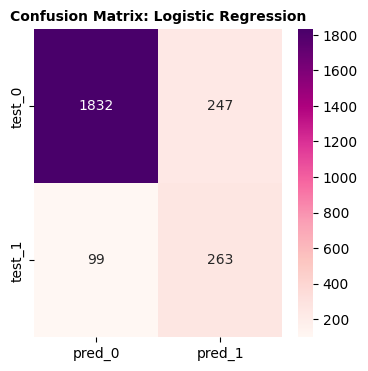

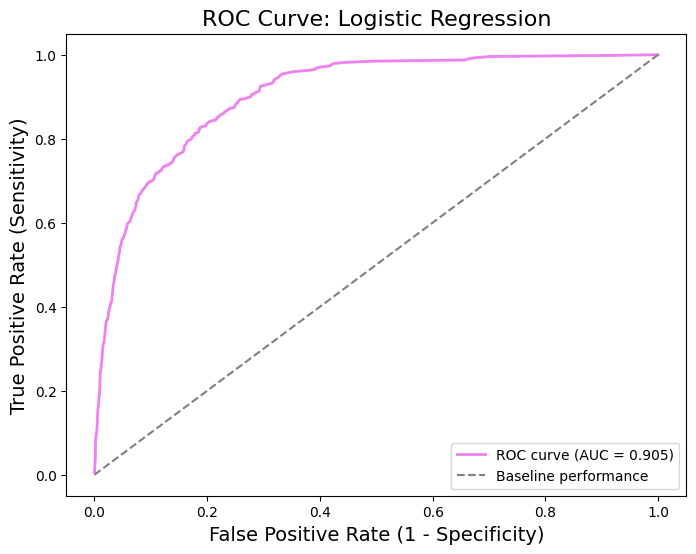

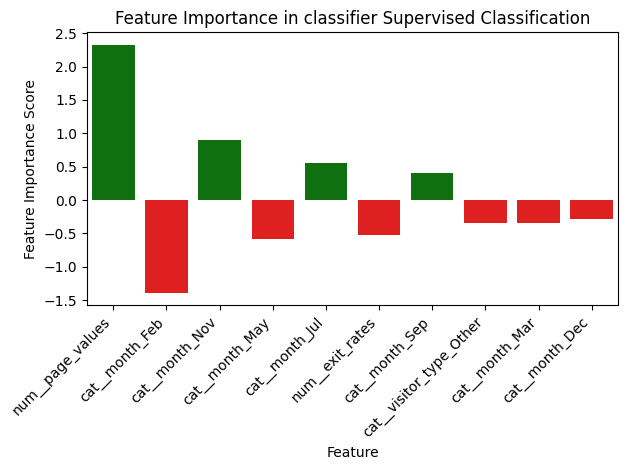


Training Random Forest...
Performing Cross-Validation for Random Forest...
time: 3.0508573055267334


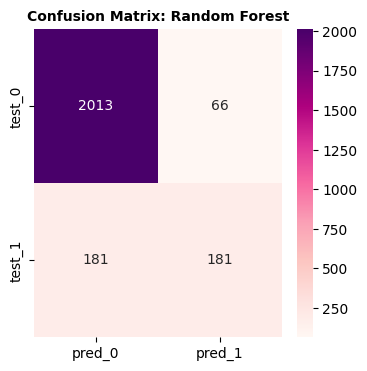

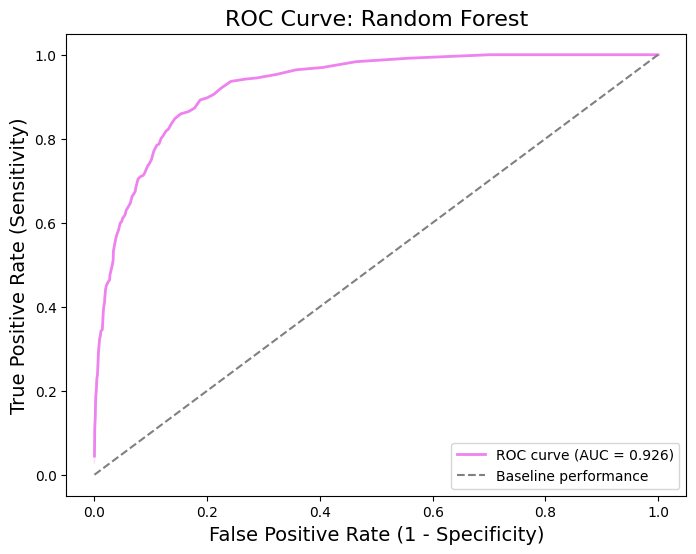

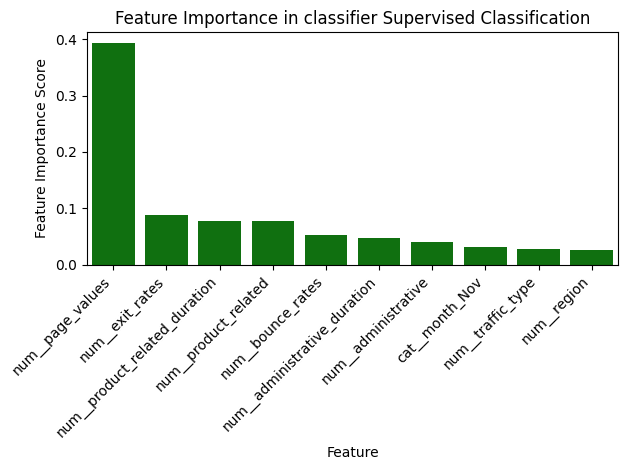


Training Gradient Boosting...
Performing Cross-Validation for Gradient Boosting...
time: 5.464871883392334


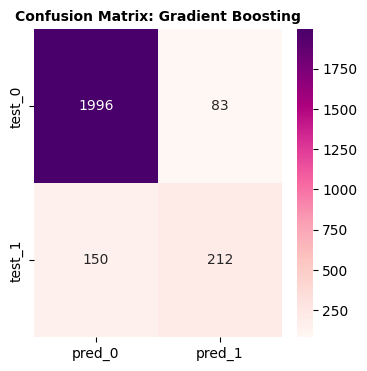

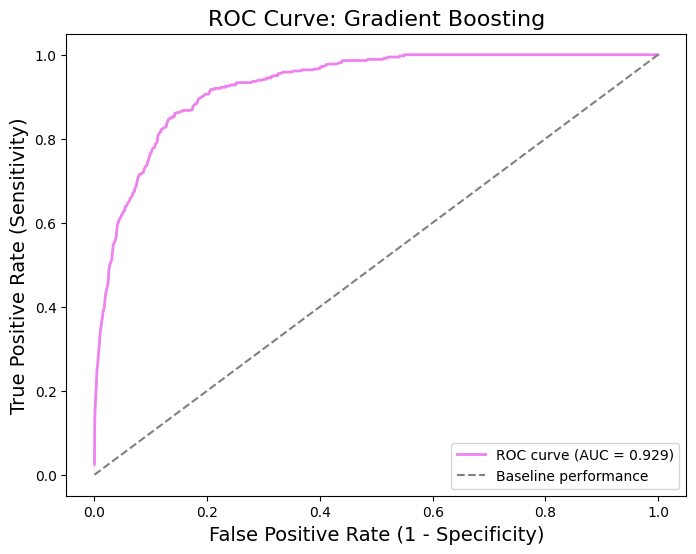

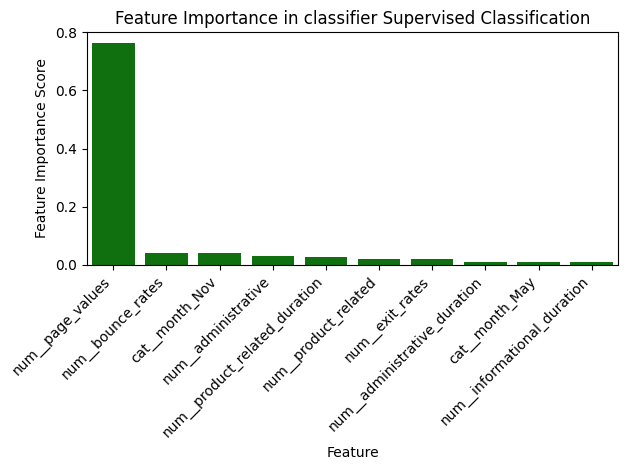


Training LightGBM...
Performing Cross-Validation for LightGBM...
[LightGBM] [Info] Number of positive: 1237, number of negative: 6574
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1904
[LightGBM] [Info] Number of data points in the train set: 7811, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.158366 -> initscore=-1.670433
[LightGBM] [Info] Start training from score -1.670433
[LightGBM] [Info] Number of positive: 1237, number of negative: 6574
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1905
[LightGBM] [Info] Number of data points in the tra

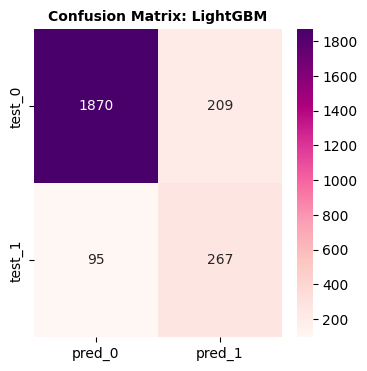

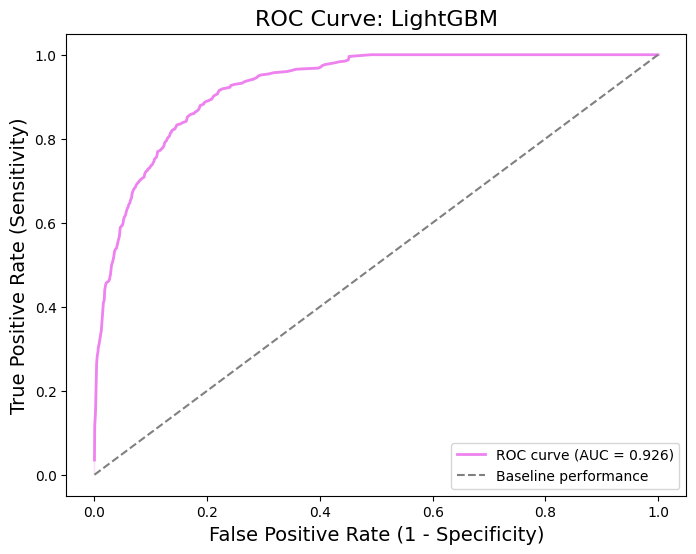

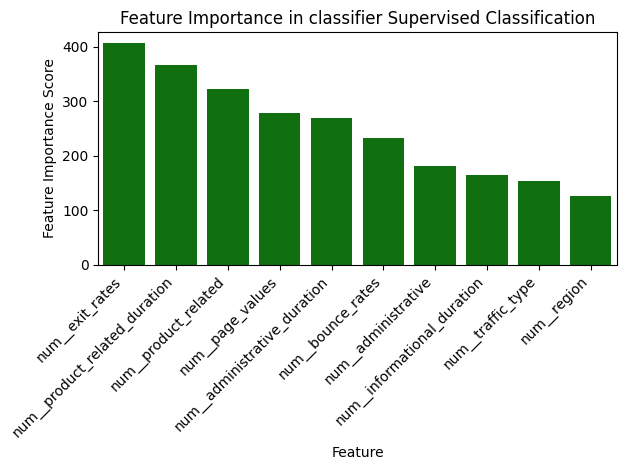


Training XGBoost...
Performing Cross-Validation for XGBoost...
time: 1.1577789783477783


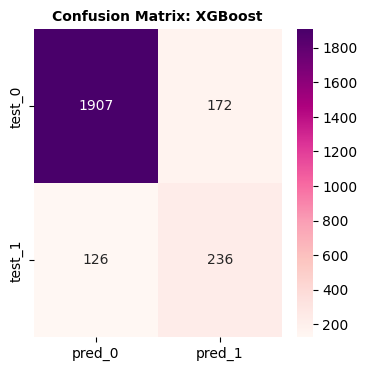

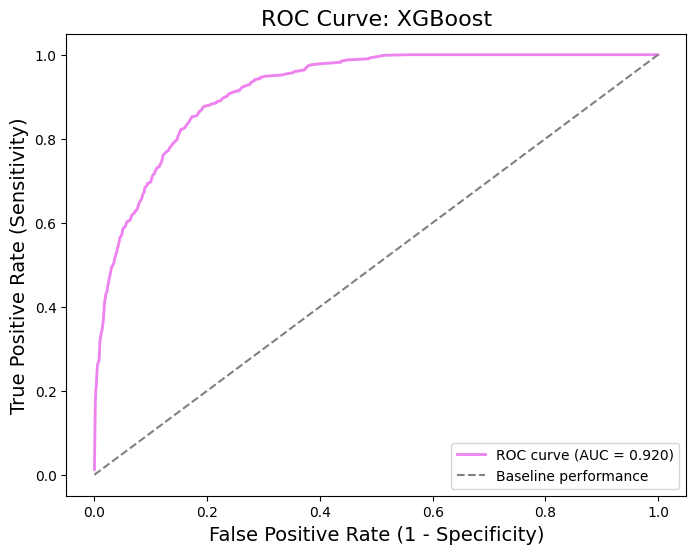

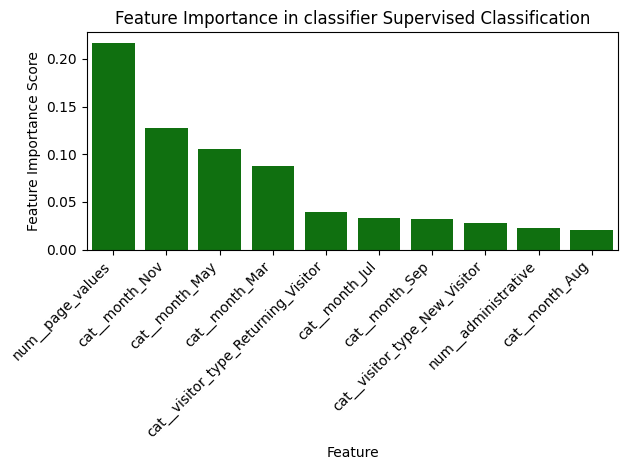


Training CatBoost...
Performing Cross-Validation for CatBoost...
time: 10.772033929824829


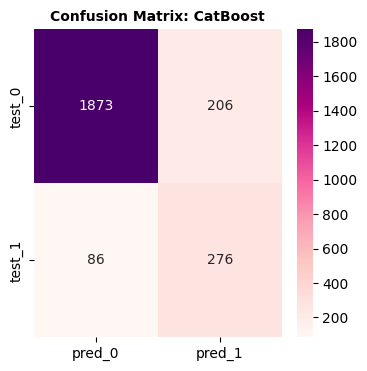

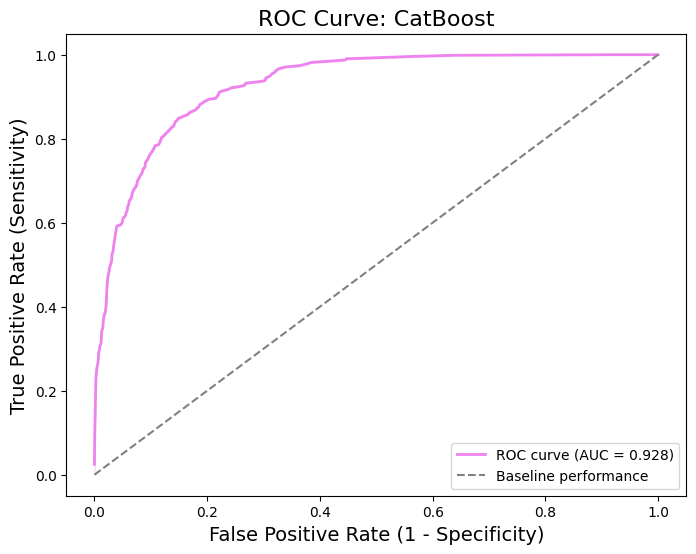

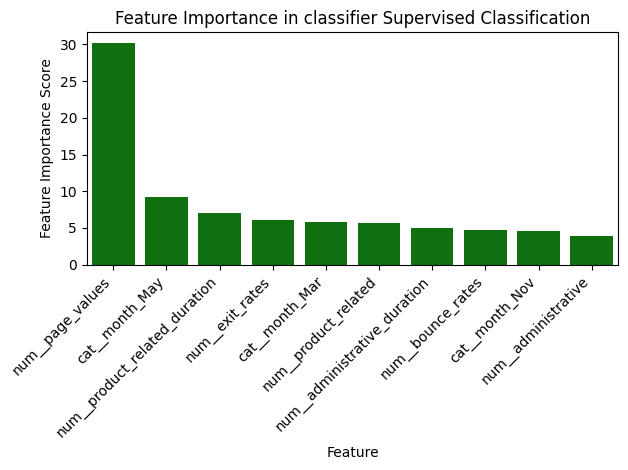

Best model saved as 'best_classifier.joblib'.


In [66]:
# Train and evaluate
results_df, trained_models, classifer_results_df = train_and_evaluate_classifiers(X, y, classifiers, 
                                                                       use_cross_validation=True, 
                                                                       use_grid_search=False, 
                                                                       grid_search_params=grid_search_params, 
                                                                       use_imbalance_handling=False)

In [45]:
results_df

,Classifier,Accuracy,Precision,Recall,F1-Score,ROC AUC,CV F1-Score,Fit Time (s)
0,Logistic Regression,0.855797,0.509579,0.734807,0.601810,0.903900,0.624492,2.814286
1,Random Forest,0.890209,0.618090,0.679558,0.647368,0.922335,0.680961,2.748976
2,Gradient Boosting,0.893486,0.623188,0.712707,0.664948,0.927770,0.693622,5.025235
3,LightGBM,0.877100,0.564854,0.745856,0.642857,0.924513,0.663144,3.497054
4,XGBoost,0.861122,0.521657,0.765193,0.620381,0.918351,0.652842,1.427321
5,CatBoost,0.882016,0.577731,0.759669,0.656325,0.928419,0.678565,10.746235


In [67]:
# Test one model performance

classifer_name_test = 'Logistic Regression'

model = trained_models[classifer_name_test]
y_pred = model.predict(X_test)

predict_vs_actual_df = pd.DataFrame({"Predicted": y_pred, "Actual": y_test})

predict_vs_actual_df.sample(10)

,Predicted,Actual
1479,0,0
4084,0,0
8211,1,1
5183,0,0
6860,0,0
9950,1,0
8021,0,1
9632,1,1
12162,1,0
5940,0,1


In [68]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['month', 'visitor_type'], dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['administrative', 'administrative_duration', 'informational',
       'informational_duration', 'product_related', 'product_related_duration',
       'bounce_rates', 'exit_rates', 'page_values', 'special_day',
       'operating_systems', 'browser', 'region', 'traffic_type', 'weekend'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

Feature: 0, Score: 0.23836
Feature: 1, Score: -0.28396
Feature: 2, Score: -1.39100
Feature: 3, Score: 0.54819
Feature: 4, Score: -0.06329
Feature: 5, Score: -0.33898
Feature: 6, Score: -0.58409
Feature: 7, Score: 0.90595
Feature: 8, Score: 0.15581
Feature: 9, Score: 0.40691
Feature: 10, Score: 0.11521
Feature: 11, Score: -0.34150
Feature: 12, Score: -0.17983
Feature: 13, Score: 0.04847
Feature: 14, Score: -0.02794
Feature: 15, Score: 0.10017
Feature: 16, Score: -0.04196
Feature: 17, Score: 0.03553
Feature: 18, Score: 0.20444
Feature: 19, Score: -0.19670
Feature: 20, Score: -0.52522
Feature: 21, Score: 2.32610
Feature: 22, Score: -0.02253
Feature: 23, Score: -0.02971
Feature: 24, Score: 0.06067
Feature: 25, Score: -0.01585
Feature: 26, Score: 0.01305
Feature: 27, Score: 0.02764


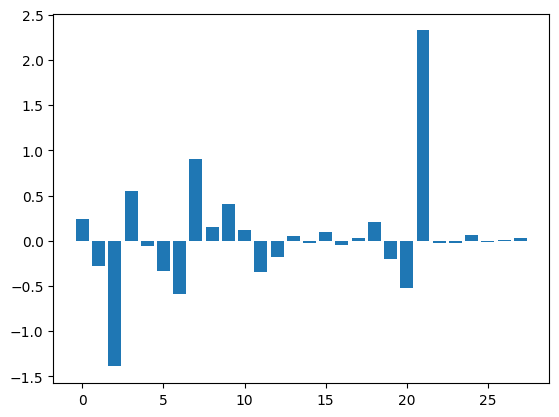

In [69]:
# get importance
importance = model.named_steps['classifier']
# Check if model type is LogisticRegression before accessing feature_importances_
if hasattr(importance, 'feature_importances_'):
	importance_scores = importance.feature_importances_
else:
	# Handle models other than LogisticRegression (assuming coef_ approach)
	importance_scores = importance.coef_[0]

# summarize feature importance
for i,v in enumerate(importance_scores):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance_scores))], importance_scores)
plt.show()

In [70]:
import shap

In [71]:
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)